# CC User Clustering
**Exercises**  
_dissashaf | May 9, 2023_

# I. Introduction

Pada proyek ini akan dilakukan pembuatan model clustering untuk mengelompokkan pengguna kartu kredit bank dalam beberapa golongan. Segmentasi diperlukan untuk melakukan strategi (pemasaran, pencegahan, pengendalian resiko, dan sebagainya) yang lebih bertarget pada golongan customer atau klien tertentu. 

**Problem statement:** 

Diperlukan model clustering untuk melakukan customer segmentation dari data kartu kredit sebuah bank yang diambil selama enam bulan terakhir. 

**Dataset:**

[Dataset](https://console.cloud.google.com/bigquery?project=bigquery-public-data-381908&supportedpurview=project&ws=!1m5!1m4!1m3!1sbigquery-public-data-381908!2sbquxjob_1af327c0_18837585a43!3sUS) yang akan dipakai adalah dataset “Credit Card Information” yang memiliki informasi pemilik kartu seperti limit, saldo, frekuensi belanja, serta informasi lainnya. Dataset ini memiliki 19 kolom informasi. Berikut adalah deskripsi beserta informasi tipe data pada masing-masing kolom yang tersedia:

| Table Name                 | Column Name                         | Data Type | Description                                                                                           |
|----------------------------|-------------------------------------|-----------|-------------------------------------------------------------------------------------------------------|
| credit-card-information    | CUST ID                             | INT64     | Identification of Credit Card holder                                                                  |
| credit-card-information    | BALANCE                             | FLOAT64   | Balance amount left in their account to make purchases                                                 |
| credit-card-information    | BALANCE FREQUENCY                   | FLOAT64   | How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated) |
| credit-card-information    | PURCHASES                           | FLOAT64   | Amount of purchases made from account                                                                 |
| credit-card-information    | ONEOFF PURCHASES                    | FLOAT64   | Maximum purchase amount done in one-go                                                                |
| credit-card-information    | INSTALLMENTS PURCHASES              | FLOAT64   | Amount of purchase done in installment                                                               |
| credit-card-information    | CASH ADVANCE                        | FLOAT64   | Cash in advance given by the user                                                                     |
| credit-card-information    | PURCHASES FREQUENCY                 | FLOAT64   | How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased) |
| credit-card-information    | ONEOFF PURCHASES FREQUENCY          | FLOAT64   | How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased) |
| credit-card-information    | PURCHASES INSTALLMENTS FREQUENCY    | FLOAT64   | How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done) |
| credit-card-information    | CASH ADVANCE FREQUENCY              | FLOAT64   | How frequently the cash in advance being paid                                                        |
| credit-card-information    | CASH ADVANCE TRX                    | INT64     | Number of Transactions made with 'Cash in Advanced'                                                   |
| credit-card-information    | PURCHASES TRX                       | INT64     | Number of purchase transactions made                                                                  |
| credit-card-information    | CREDIT LIMIT                        | FLOAT64   | Limit of Credit Card for user                                                                         |
| credit-card-information    | PAYMENTS                            | FLOAT64   | Amount of Payment done by user                                                                        |
| credit-card-information    | MINIMUM PAYMENTS                    | FLOAT64   | Minimum amount of payments made by user                                                               |
| credit-card-information    | PRC FULL PAYMENT                    | FLOAT64   | Percent of full payment paid by user                                                                  |
| credit-card-information    | TENURE                              | INT64     | Tenure of credit card service for use                                                                 |

**Question and Assumptions:**

Dalam proyek ini juga akan ada beberapa pertanyaan dan asumsi yang menjadi ketertarikan dari proyek ini, yakni:
1. Bagaimanakah persebaran data serta apa hal yang menarik pada data?
2. Apa insight yang didapatkan dari customer segmentation tersebut?
3. Apa kelebihan dan kekurangan dari model berkaitan dengan domain?
4. Apa yang dapat dikembangkan dari proyek ini (baik dalam modelling maupun proses lainnya)?

# II. Import Libraries
Berisi library yang akan digunakan dalam project.

In [470]:
# library math dan visualisasi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# seleksi fitur
from statsmodels.stats.outliers_influence import variance_inflation_factor
# transformation
from feature_engine.outliers import Winsorizer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.mixture import GaussianMixture
from feature_engine.transformation import LogTransformer, YeoJohnsonTransformer

# modelling
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# evaluasi
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score

# save model& inferencing
import pickle
import json

import warnings
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)

# III. Data Loading
Bagian ini berisikan data loading serta pengecekan mengenai banyak data, isi data, ukuran data, dan sebagainya untuk mengetahui bagian apa yang berpotensi untuk diamati lebih lanjut.
Berikut adalah code yang digunakan dalam filtering query:

```sql
SELECT *
FROM (
  SELECT *, ROW_NUMBER() OVER() AS row_num
  FROM `ftds-hacktiv8-project.phase1_ftds_019_rmt.credit-card-information`
)
WHERE MOD(row_num, 2) = 1 --mendapatkan kolom ganjil (batch 019)
```

In [388]:

# loading data
df = pd.read_csv('h8dsft_P1G4_R_Dissa.csv')
df.shape

(4475, 19)

In [3]:

# menampilkan 10 data pertama
df.head(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,row_num
0,788,16.581535,0.125000,200.0,0.0,200.0,0.0,0.125,0.000,0.125,0.0,0,2,1200.0,0.000000,NaN,0.0,8,1
1,2322,1.979916,0.125000,80.0,80.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,0.000000,NaN,0.0,8,3
2,3426,461.455720,1.000000,585.0,585.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1000.0,258.032630,151.696433,0.0,8,5
3,4266,2237.238086,1.000000,120.0,120.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,2500.0,343.102984,712.986387,0.0,8,7
4,4680,424.994385,0.375000,1200.0,1200.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1200.0,57.266292,56.720210,0.0,8,9
5,5884,18.885677,0.375000,57.0,57.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1500.0,0.000000,NaN,0.0,8,11
6,6291,264.566591,0.375000,1150.0,1150.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,1200.0,3029.380326,85.428885,0.0,8,13
7,8299,611.561026,1.000000,765.0,765.0,0.0,0.0,0.125,0.125,0.000,0.0,0,1,2000.0,204.464151,146.352314,0.0,8,15
8,8805,105.333584,0.375000,306.0,306.0,0.0,0.0,0.125,0.125,0.000,0.0,0,2,6000.0,101.986927,118.324082,0.0,8,17
9,24,0.004816,0.545455,51.7,0.0,51.7,0.0,0.250,0.000,0.250,0.0,0,3,3000.0,33.249088,0.059481,0.0,12,19


In [4]:

# menampilkan 10 data terakhir
df.tail(10)

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,row_num
4465,7211,1135.703750,1.000000,92.07,0.00,92.07,81.509491,0.272727,0.000000,0.181818,0.272727,3,3,1200.0,355.798199,434.689529,0.000000,11,8931
4466,8295,185.984965,0.454545,482.24,392.24,90.00,903.843591,0.272727,0.181818,0.090909,0.272727,8,8,1200.0,2333.997439,160.900585,0.250000,11,8933
4467,6900,7468.012010,1.000000,1569.41,796.07,773.34,4500.288676,0.545455,0.454545,0.363636,0.272727,7,10,8700.0,2162.943350,4628.802111,0.000000,11,8935
4468,1226,706.327578,0.888889,169.54,169.54,0.00,1406.735573,0.333333,0.333333,0.000000,0.888889,14,3,2500.0,302.976780,142.597254,0.000000,9,8937
4469,8855,3531.167073,0.900000,797.50,577.83,219.67,5273.226918,0.700000,0.400000,0.500000,0.900000,33,21,4000.0,2979.546700,3052.080103,0.000000,10,8939
4470,2345,9629.808851,1.000000,0.00,0.00,0.00,4372.393835,0.000000,0.000000,0.000000,0.545455,9,0,12000.0,2468.988022,2134.295731,0.000000,11,8941
4471,6785,1040.030221,1.000000,0.00,0.00,0.00,1390.648290,0.000000,0.000000,0.000000,0.545455,18,0,1400.0,290.129620,287.994171,0.000000,11,8943
4472,8447,1060.391273,1.000000,0.00,0.00,0.00,1475.858013,0.000000,0.000000,0.000000,0.545455,10,0,2000.0,407.360560,277.084736,0.000000,11,8945
4473,4296,3386.490883,1.000000,560.98,427.22,133.76,2008.153534,1.000000,0.727273,0.363636,0.545455,9,20,10100.0,1039.000037,886.050237,0.000000,11,8947
4474,4476,4840.545574,1.000000,1595.93,1595.93,0.00,4359.325750,0.454545,0.454545,0.000000,0.545455,17,25,6000.0,905.844846,2376.919568,0.090909,11,8949


In [5]:

# melihat informasi general data; tipe data serta jumlah data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4475 entries, 0 to 4474
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           4475 non-null   int64  
 1   BALANCE                           4475 non-null   float64
 2   BALANCE_FREQUENCY                 4475 non-null   float64
 3   PURCHASES                         4475 non-null   float64
 4   ONEOFF_PURCHASES                  4475 non-null   float64
 5   INSTALLMENTS_PURCHASES            4475 non-null   float64
 6   CASH_ADVANCE                      4475 non-null   float64
 7   PURCHASES_FREQUENCY               4475 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        4475 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  4475 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            4475 non-null   float64
 11  CASH_ADVANCE_TRX                  4475 non-null   int64  
 12  PURCHA

In [6]:
# melihat deskripsi serta tendensi sentral data
df.describe()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,row_num
count,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4475.000000,4474.000000,4475.000000,4310.000000,4475.000000,4475.000000,4475.000000
mean,4469.762235,1598.572544,0.875942,989.305377,579.183245,410.486275,986.753334,0.490696,0.201015,0.367512,0.135027,3.284469,14.583911,4520.497340,1739.111431,850.057963,0.154547,11.531844,4475.000000
std,2583.768465,2142.821490,0.239338,2049.011506,1568.102088,870.834440,2037.334052,0.401467,0.299677,0.397832,0.199675,6.891211,25.206023,3631.271706,2866.795318,2166.271729,0.294493,1.319383,2583.931114
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000,1.000000
25%,2239.500000,128.814030,0.881945,39.915000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.977477,169.771559,0.000000,12.000000,2238.000000
50%,4478.000000,874.583247,1.000000,358.200000,27.980000,95.760000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,865.944520,312.452292,0.000000,12.000000,4475.000000
75%,6707.500000,2064.014256,1.000000,1105.815000,564.410000,472.115000,1119.565480,0.916667,0.285714,0.750000,0.222222,4.000000,17.000000,6500.000000,1934.318215,842.176740,0.142857,12.000000,6712.000000
max,8948.000000,18495.558550,1.000000,40040.710000,33803.840000,15497.190000,29282.109150,1.000000,1.000000,1.000000,1.250000,123.000000,358.000000,30000.000000,40627.595240,56370.041170,1.000000,12.000000,8949.000000


Secara garis besar tidak ditemukan nilai minus yang menandakan data siap untuk dieksplorasi lebh lanjut. 

# IV. EDA

Berisi eksplorasi data pada dataset yang akan dilakukan pembuatan query, grouping, serta visualisasi data. Bagian ini akan menekankan deskripsi serta keterhubungan data secara prinsip.

### Data Cleaning

In [7]:
# melihat apakah ada data terduplikasi
# bila tidak ada, tidak dilakukan proses apapun

df.duplicated().sum()

0

In [8]:
# melihat jika ada data yang hilang
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    165
PRC_FULL_PAYMENT                      0
TENURE                                0
row_num                               0
dtype: int64

Untuk kolom 'CREDIT_LIMIT' diketahui memiliki satu baris yang hilang, maka baris tersebut akan dihapus karena dianggap hanya berjumlah sedikit dan tidak akan begitu memengaruhi data.
Sementara itu kolom 'MINIMUM_PAYMENTS' memiliki 165 baris dengan value yang hilang. Karena sebelumnya telah diketahui bahwa data tidak normal (nilai skewness 12.6), makan akan dilakukan imputasi dengan median.

Selanjutnya, karena permodelan yang akan digunakan yakni K-Means lebih compatible untuk data nimerikal asli, maka kolom yang diasumsikan sebagai kategorikal; 'CUST_ID', 'TENURE', serta seluruh kolom dengan '...FREQUENCY' dan 'PRC' yang dianggap belum penting untuk pembuatan model kali ini akan disingkirkan. 

In [389]:
# karena satu baris dari CREDIT_LIMIT missing, maka dilakukan penghapusan baris saja
df.dropna(subset=['CREDIT_LIMIT'], inplace=True)

# melakukan fillna dengan median dari MINIMUM_PAYMENTS
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)


# drop row yang terbentuk dari query sql
df.drop(['row_num'], axis=1, inplace=True)

# drop kolom id
df.drop(['CUST_ID'], axis=1, inplace=True)

# drop semua kolom dengan 'frequency'
df_drop = df.copy()
# drop kolom kategorikal
df_drop.drop(['TENURE'], axis=1, inplace=True)
df_drop = df_drop.drop(['CASH_ADVANCE_FREQUENCY', 'BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY','PRC_FULL_PAYMENT'], axis=1)



Data sudah tersaring dari missing values serta kolom yang tidak diinginkan.

### Split Numerical Categorical

In [61]:
# memasukan pada variabel bila ingin diakses lagi
cat_cols = ['CASH_ADVANCE_FREQUENCY', 'BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'TENURE','PRC_FULL_PAYMENT']
num_cols = df_drop.columns

Alasan serta asumsi dari pembagian kolom tersebut adalah:

- 'TENURE' yang merupakan kolom untuk menandakan jangka waktu penggunaan kartu (dari 1-12 bulan dengan 7 value unik) akan dianggap sebagai data kategorikal karena dapat dianggap sebagai tingkat loyalitas peminjam kartu.
- Semua kolom '...FREQUENCY' memiliki value dari 0.0-1.00 hingga 0-1.25 (*continous* non-biner). Kolum-kolum ini bukan ditetapkan dengan pasti bahwa mereka adalah kolom kategorikal--melainkan disingkirkan karena bentuknya yang merupakan persentase. Kolom persentase diasumsikan kurang cocok untuk model K-means karena memiliki skala serta sistem pendataan yang sedikit berbeda. Intinya, `pemisahan kolom-kolom '...FREQUENCY'` (yang masih diragukan jenisnya) diupayakan untuk memastikan bahwa kolom yang akan kita pakai nantinya hanyalah `kolom numerikal asli`. 

In [440]:
# karena data kategorial sudah dilakukan encoding dari dataset asli, perlu dilakukan pembuatan tabel describe secara manual
# membuat dataframe kosong
description_cat = pd.DataFrame(columns=['Column', 'Unique Values', 'Count Unique', 'Top Value'])

# iterasi masing-masing kolom terhadap rumus count, top, dll
for column in cat_cols:
    unique_values = df[column].unique()
    count = df[column].nunique()
    top_value = df[column].value_counts().idxmax()
    description_cat = description_cat.append({'Column': column, 'Unique Values': unique_values, 'Count Unique': count, 'Top Value': top_value}, ignore_index=True)

# show
description_cat

,Column,Unique Values,Count Unique,Top Value
0,CASH_ADVANCE_FREQUENCY,"[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0....",49,0.0
1,BALANCE_FREQUENCY,"[0.125, 1.0, 0.375, 0.545455, 0.454545, 0.3636...",43,1.0
2,PURCHASES_FREQUENCY,"[0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, ...",47,1.0
3,ONEOFF_PURCHASES_FREQUENCY,"[0.0, 0.125, 0.083333, 0.25, 0.166667, 0.375, ...",45,0.0
4,PURCHASES_INSTALLMENTS_FREQUENCY,"[0.125, 0.0, 0.25, 0.166667, 0.083333, 0.5, 0....",47,0.0
5,TENURE,"[8, 12, 10, 6, 9, 11, 7]",7,12.0
6,PRC_FULL_PAYMENT,"[0.0, 0.166667, 0.222222, 0.25, 0.090909, 1.0,...",47,0.0


In [433]:
# melihat deskripsi data numerikal
df[num_cols].describe()

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS
count,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000,4474.000000
mean,1598.925734,989.526500,579.312700,410.578024,986.932122,3.284980,14.587170,4520.497340,1739.498125,830.421973
std,2142.930731,2049.187135,1568.253448,870.910147,2037.526666,6.891897,25.207897,3631.271706,2866.999032,2128.565739
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163
25%,129.434051,40.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,384.084795,171.360601
50%,874.843126,358.270000,27.990000,95.780000,0.000000,0.000000,7.000000,3000.000000,866.739506,312.560636
75%,2064.060234,1105.852500,564.705000,472.127500,1120.167669,4.000000,17.000000,6500.000000,1934.572096,799.287284
max,18495.558550,40040.710000,33803.840000,15497.190000,29282.109150,123.000000,358.000000,30000.000000,40627.595240,56370.041170


In [62]:
# melihat bentuk penyebaran data
df.apply(lambda x: round(x.skew(), 3))

BALANCE                              2.349
BALANCE_FREQUENCY                   -2.011
PURCHASES                            7.573
ONEOFF_PURCHASES                     8.558
INSTALLMENTS_PURCHASES               6.539
CASH_ADVANCE                         4.202
PURCHASES_FREQUENCY                  0.058
ONEOFF_PURCHASES_FREQUENCY           1.543
PURCHASES_INSTALLMENTS_FREQUENCY     0.499
CASH_ADVANCE_FREQUENCY               1.811
CASH_ADVANCE_TRX                     5.816
PURCHASES_TRX                        5.035
CREDIT_LIMIT                         1.456
PAYMENTS                             5.628
MINIMUM_PAYMENTS                    12.856
PRC_FULL_PAYMENT                     1.933
TENURE                              -3.007
dtype: float64

Berdasarkan nilai skewness tersebut, diketahui bahwa:
- Kolom 'BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'PAYMENTS', 'MINIMUM_PAYMENTS' memiliki skewnes yang sangat positif atau sangat miring ke kanan. 
- Kolom 'PRC_FULL_PAYMENT', 'CREDIT_LIMIT', 'CASH_ADVANCE_FREQUENCY', dan 'ONEOFF_PURCHASES_FREQUENCY' memiliki skewness yang positif namun mendekati angka 1.
- Kolom 'BALANCE_FREQUENCY' memiliki skewness negatif yang berarti rata-ratanya melebihi median. 
- Kolom 'PURCHASES_FREQUENCY' dan 'PURCHASES_INSTALLMENTS_FREQUENCY' memiliki skewnes yang mendekati angka 0.

### Outlier

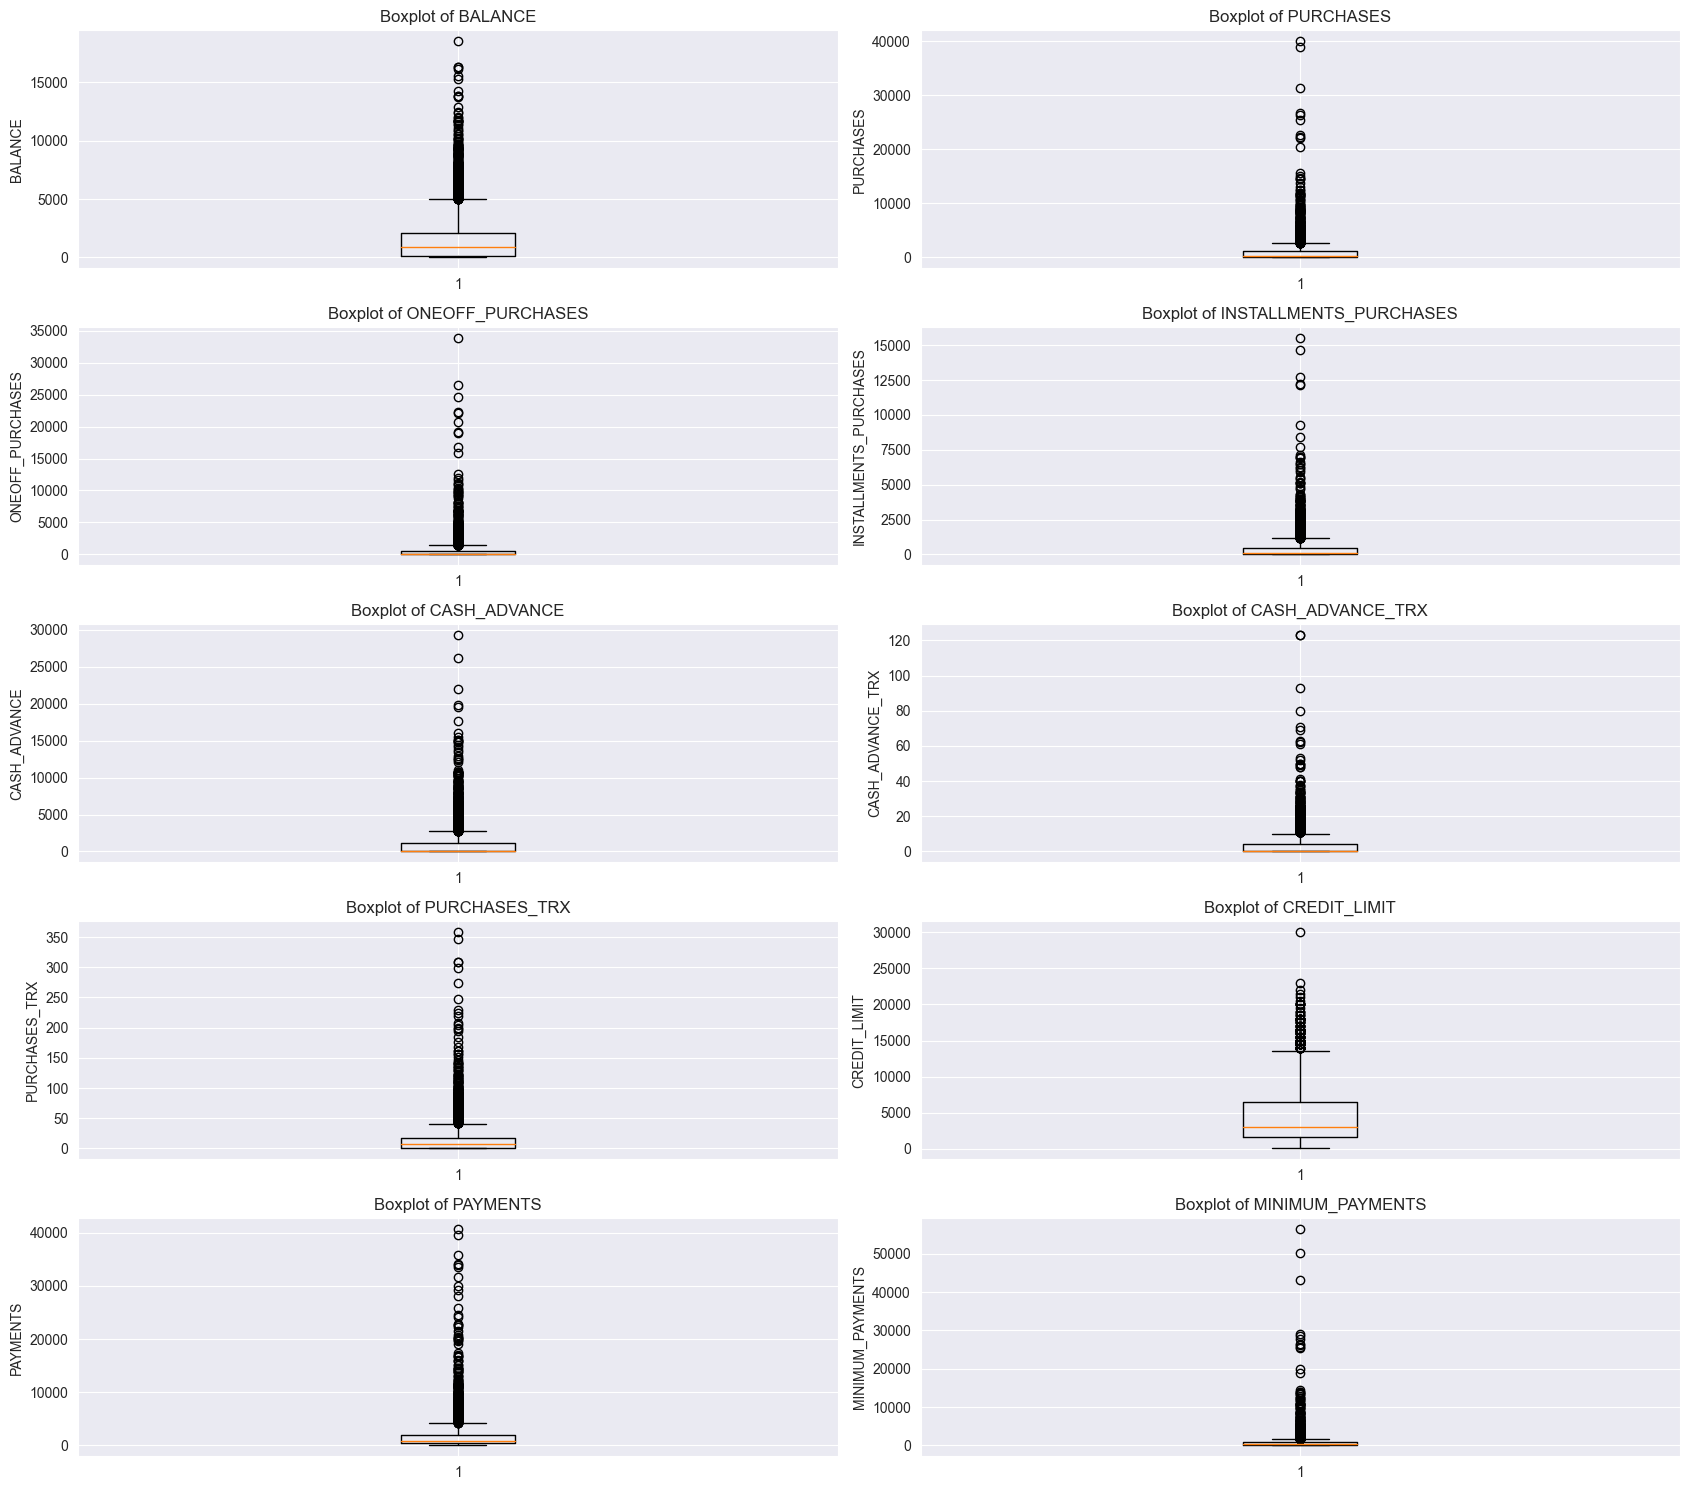

In [70]:
# membuat canvas
fig, axes = plt.subplots(5, 2, figsize=(17, 15))

# membuat box plot untuk melihat outlier pada data numerikal
for i, col in enumerate(num_cols):
    ax = axes[i // 2, i % 2]
    ax.boxplot(df[col])
    ax.set_title(f'Boxplot of {col}')
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

Ditemukan adanya outlier pada seluruh kolom numerikal. Selanjutnya akan ditelusuri lebih lanjut mengenai teknik handling yang paling cocok untuk kolom-kolom ini pada bagian pre-processing.

### Visualization



**Categorical**

Karena kolom 'kategorikal' sudah berupa persentase numerik yang terdiri atas banyak value unik, maka akan dilakukan visualisasi histogram.

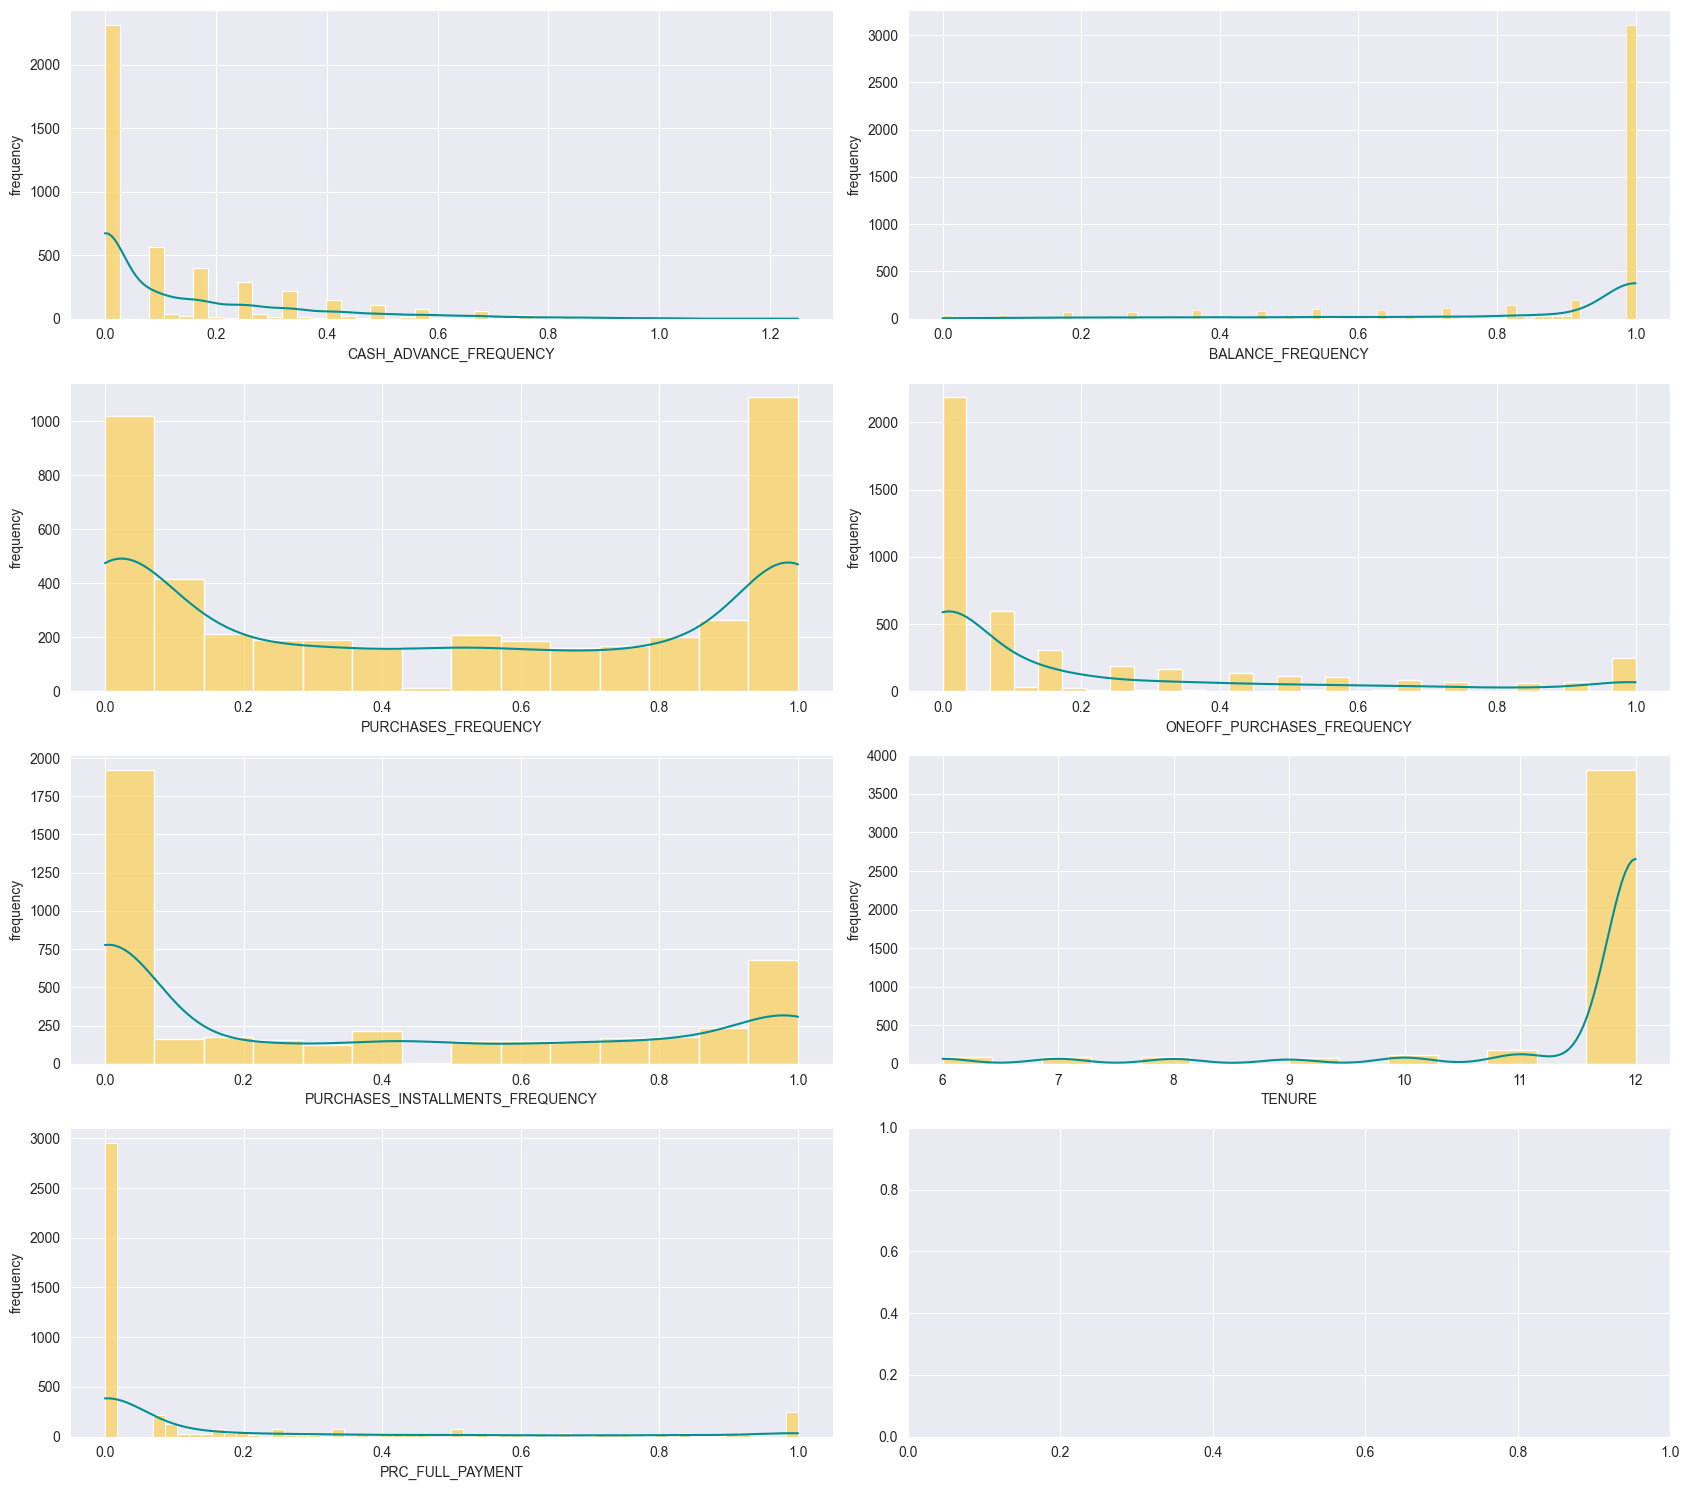

In [63]:
# Membuat canvas
fig, axes = plt.subplots(4, 2, figsize=(17, 15))

# looping histogram
for i, ax in enumerate(axes.flatten()):
    if i < len(cat_cols):
        # Membuat histogram
        sns.histplot(data=df, x=cat_cols[i], color = '#fccf55', alpha=0.7, ax=ax, kde=True)
        ax.lines[0].set_color('#009094') # mengganti warna garis 
        ax.set_xlabel(cat_cols[i])
        ax.set_ylabel('frequency')
        ax.grid(True, color='white')  # grid untuk memudahkan visualisai

# show plot
sns.set_style('darkgrid')
plt.tight_layout()
plt.show()

Berdasarkan deskripsi beserta visualisasi, dapat diketahui bahwa:

- 'CASH_ADVANCE_FREQUENCY': Memiliki rata-rata 0,13 dengan 0.0 sebagai frekuensi terbanyak. Hal ini menunjukkan bahwa pada dataset ini, banyak peminjam yang `tidak meminjam` dengan metode cash. Hal ini wajar karena menggunakan cash akan memberikan tarif yang lebih tinggi dan kurang menguntungkan. 
- 'BALANCE_FREQUENCY': Memiliki modus 1.0 yang menandakan bahwa mayoritas kreditur selalu memberikan update sisa saldo yang dapat peminjam gunakan. 
- 'PURCHASES_FREUENCY': Memiliki modus 1.0 dan disusul oleh 0.0. Kolom ini memiliki persebaran data berbentuk U-shaped. Hal ini menunjukkan bahwa mayoritas peminjam ada yang `sangat sering` berbelanja dan ada yang `sama sekali jarang` berbelanja. 
- 'ONEOFF_PURCHASES_FREQUENCY': Memiliki modus 0.0 yang berarti kebanyakan peminjam mungkin lebih memiliki untuk menggunakan metode cicilan, atau mungkin memang `jarang berbelanja` secara general.
- 'PURCHASES_INSTALLMENTS_FREQUENCY': Memiliki modus 0.0 dan disusul oleh 1.0 yang menandakan seberapa sering peminjam menggunakan metode cicilan. Kolom ini memiliki persebaran data berbentuk U-shaped. Hal ini menunjukkan bahwa kebanyakan peminjam memang jarang berbelanja karena baik one-off maupun installment keduanya dimayoritasi oleh value 0.0.
- 'TENURE': Memiliki modus 12 yang menggambarkan seberapa lama peminjam telah menggunakan jasa kreditur. Hal ini dapat menunjukkan mayoritas data ini memiliki data peminjam yang sudah menggunakan kredit selama setahun--namun dapat juga menunjukkan `seberapa loyal` peminjam menggunakan jasa kreditur tersebut. 
- 'PRC_FULL_PAYMENT': Memiliki modus 0.0 yang menandakan bahwa kebanyakan pemimjam tidak langsung melakukan pelunasan total. Hal ini dapat menyebabkan gagal bayar.

**Numerical**

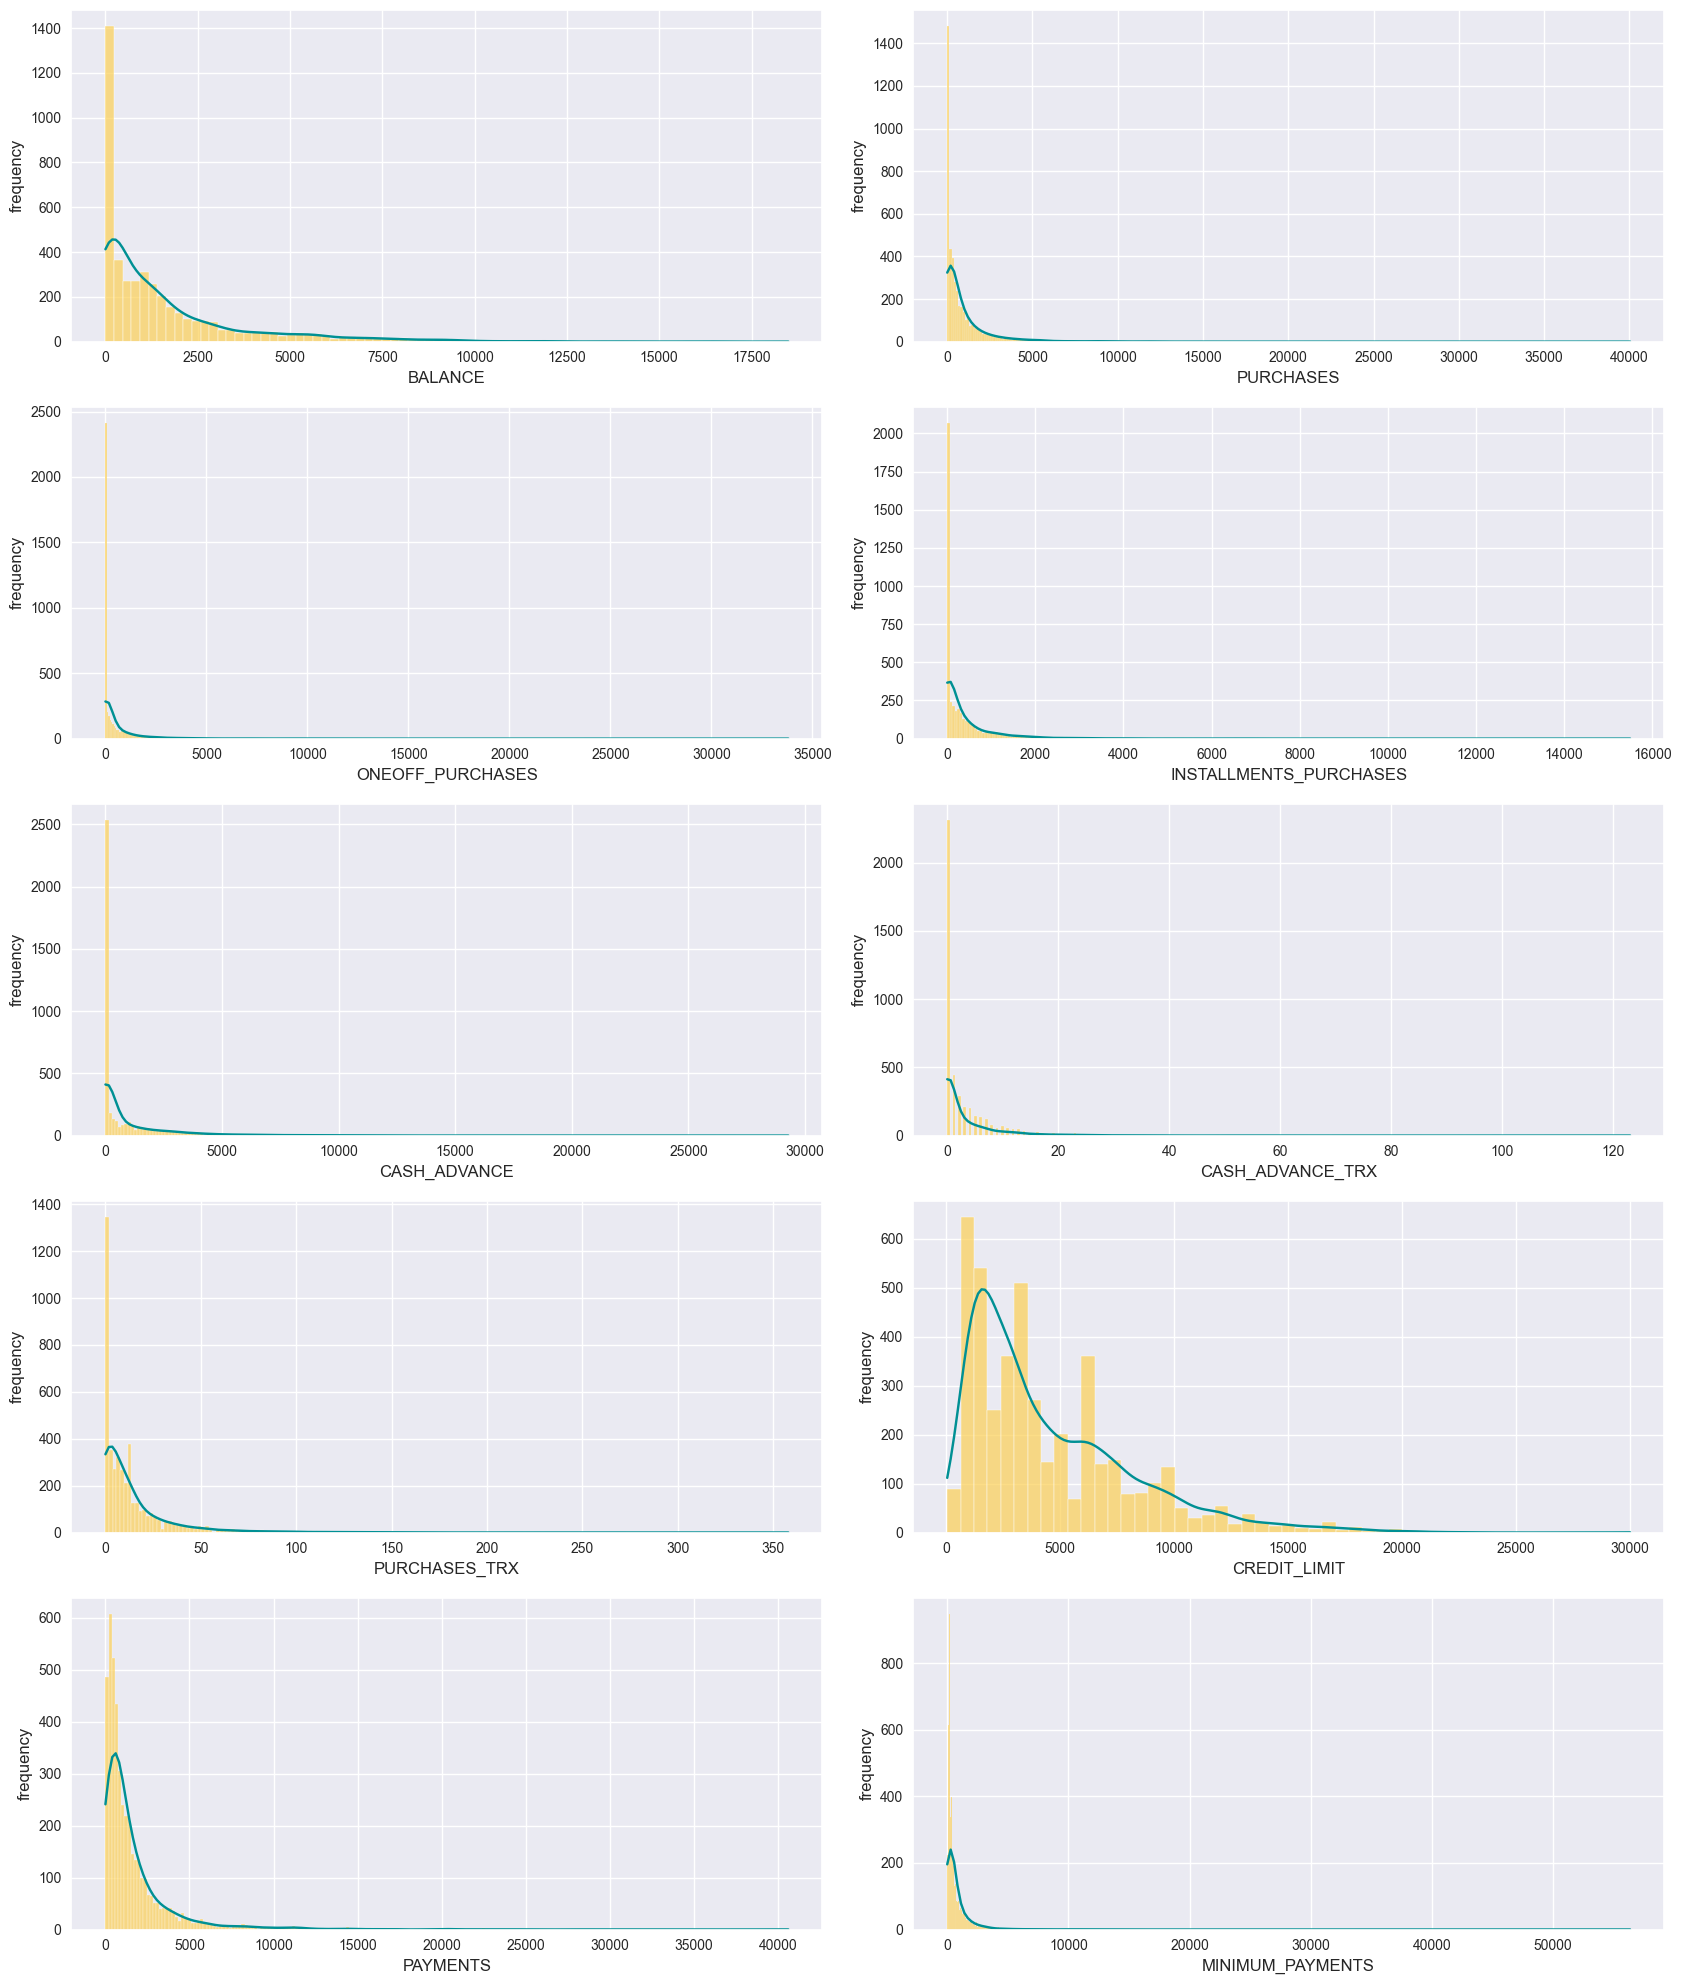

In [416]:
# Membuat canvas
fig, axes = plt.subplots(5,2, figsize=(17, 20))

# looping histogram
for i, ax in enumerate(axes.flatten()):
    if i < len(num_cols):
        # Membuat histogram
        sns.histplot(data=df_drop, x=num_cols[i], color = '#fccf55', alpha=0.7, ax=ax, kde=True)
        ax.lines[0].set_color('#009094') # mengganti warna garis fccf55
        ax.set_xlabel(num_cols[i])
        ax.set_ylabel('frequency')
        ax.grid(True, color='white')  # grid untuk memudahkan visualisai

# show plot
sns.set_style('darkgrid')
plt.tight_layout()
plt.show()


Berdasarkan visualisasi tersebut, dapat diketahui bahwa:

- 'BALANCE': Memiliki rata-rata kisaran 1,598. Hal ini menunjukkan bahwa pada dataset ini, banyak peminjam yang `menghabiskan sisa limitnya` hingga batas bulanannya mencapai angka nol.
- 'PURCHASES': Memiliki rata-rata 989 dengan kisaran frekuensi terbanyak pada angka 0-1000. Hal ini menunjukkan bahwa kebanyakan peminjam tidak melakukan transaksi berjumlah tinggi.  
- 'ONEOFF_PURCHASES': Memiliki rata-rata 579 dengan kisaran 0-700.
- 'INSTALLMENTS_PURCHASES': Memiliki rata-rata 410 dengan kisaran total 0-600. Melihat dari ketiga kolom purchase, sepertinya memang kebanyakan peminjam hanya berbelanja dengan `total yang rendah`.
- 'CASH_ADVANCE': Memiliki rata-rata senilai 968. Berhubungan dengan CASH_ADVANCE_FREQUENCY, memang jarang peminjam ingin meminjam uang dalam bentuk cash (karena tarif yang tingg). Oleh karena itu mungkin menyebabkan total uang dari CASH_ADVANCE juga tidak menunjukkan angka yang tinggi. 
- 'CASH_ADVANCE_TRX': Memiliki rata-rata sebanyak tiga kali transaksi cash per customer.
- 'PURCHASES_TRX': Memiliki rata-rata sebanyak 14 kali per customer yang menunjukkan bahwa customer lebih sering melakukan `pembelian dibandingkan peminjaman cash` (cash hanya tiga kali). 
- 'CREDIT_LIMIT': Memiliki frekuensi kisaran 0-5000, menandakan bahwa mayoritas peminjam merupakan kalangan menegah hingga `menengah ke atas`. 
- 'PAYMENTS': Memiliki frekuensi kisaran 0-2500, menandakan bahwa mayoritas peminjam memiliki daya bayar yang cukup baik karena lebih tinggi dibandingkan PURCHASES.
- 'MINIMUM_PAYMENTS': Memiliki rentang 0.01 hingga 56,370 dengan rata-rata kisaran 0-1000.


**Other Correlation**

<Axes: xlabel='CASH_ADVANCE', ylabel='PAYMENTS'>

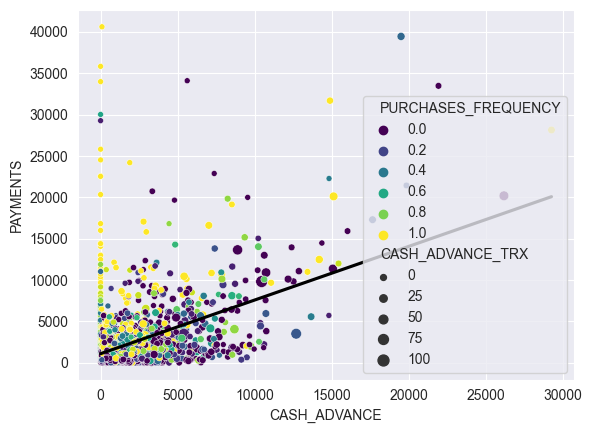

In [99]:
# scatter plot untuk peminjaman cash, pembayaran, serta frekuensi pembelian dan pemijaman cash
sns.scatterplot(x='CASH_ADVANCE',y='PAYMENTS',data=df,hue='PURCHASES_FREQUENCY', size = 'CASH_ADVANCE_TRX', palette='viridis')
sns.regplot(x='CASH_ADVANCE', y='PAYMENTS', data=df, scatter=False, color='black', ci=None)

Peminjam yang melakukan peminjaman cash biasanya meminjam dengan jumlah yang tidak sedikit atau sebanyak 10,000 (terlihat dari posisi lingkaran yang besar). Selain itu, peminjam yang sering berbelanja biasanya jarang meminjam cash.

<Axes: xlabel='PURCHASES', ylabel='PURCHASES_TRX'>

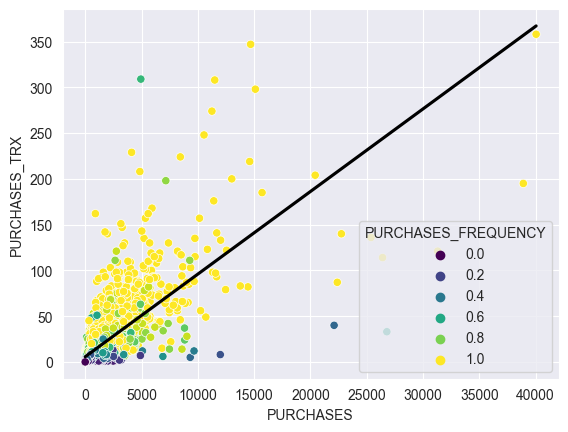

In [80]:
# scatter plot untuk pembelian, transaksi, serta frekuensinya
sns.scatterplot(x='PURCHASES',y='PURCHASES_TRX',data=df,hue='PURCHASES_FREQUENCY', palette='viridis')
sns.regplot(x='PURCHASES', y='PURCHASES_TRX', data=df, scatter=False, color='black', ci=None)

Peminjam yang sering berbelanja biasanya memiliki jumlah transaksi serta jumlah total belanjaan yang lebih tinggi juga. 

<Axes: xlabel='BALANCE', ylabel='CREDIT_LIMIT'>

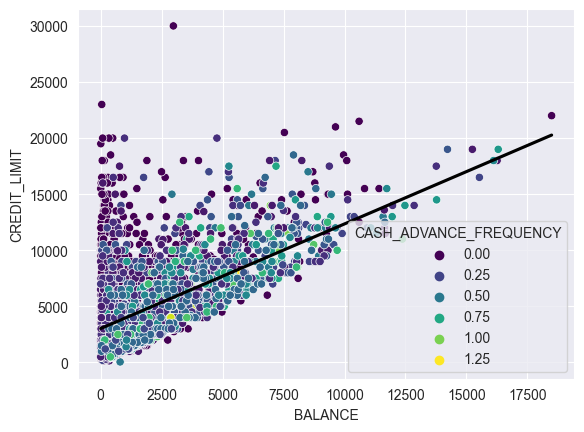

In [87]:
# scatter plot untuk saldo, limit, dan frekuensi peminjaman cash
sns.scatterplot(x='BALANCE',y='CREDIT_LIMIT',data=df,hue='CASH_ADVANCE_FREQUENCY', palette='viridis')
sns.regplot(x='BALANCE', y='CREDIT_LIMIT', data=df, scatter=False, color='black', ci=None)

Peminjam yang memiliki sisa balance sedikit serta limit sedikit biasanya lebih sering mengambil dana cash. 

<Axes: xlabel='BALANCE', ylabel='CREDIT_LIMIT'>

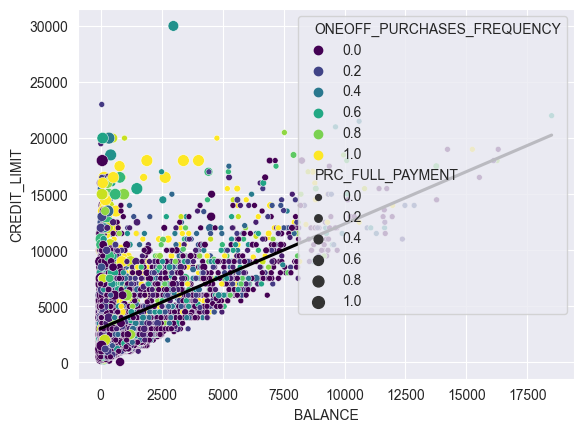

In [98]:
# scatter plot untuk saldo, limit, dan frekuensi pembelian tunggal
sns.scatterplot(x='BALANCE',y='CREDIT_LIMIT',data=df,hue='ONEOFF_PURCHASES_FREQUENCY',size='PRC_FULL_PAYMENT', palette='viridis')
sns.regplot(x='BALANCE', y='CREDIT_LIMIT', data=df, scatter=False, color='black', ci=None)

Peminjam atau pengguna kartu kredit yang memiliki limit lebih tinggi cenderung lebih sering untuk melakukan one-off atau pembelian tunggal. Selain itu, pengguna yang memiliki limit tinggi juga lebih cenderung melakukan pelunasan kreditnya. 

<Axes: xlabel='BALANCE', ylabel='CREDIT_LIMIT'>

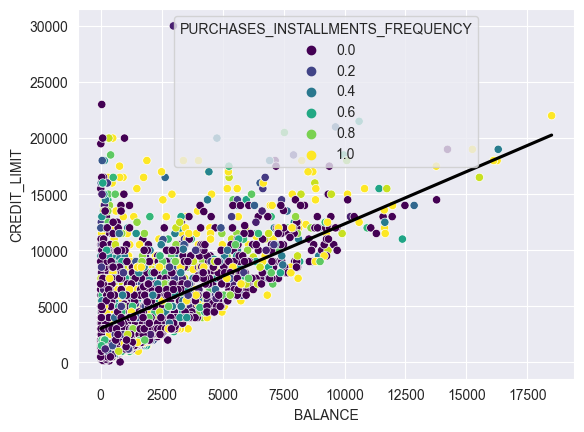

In [90]:
# scatter plot untuk saldo, limit, dan frekuensi cicilan
sns.scatterplot(x='BALANCE',y='CREDIT_LIMIT',data=df,hue='PURCHASES_INSTALLMENTS_FREQUENCY', palette='viridis')
sns.regplot(x='BALANCE', y='CREDIT_LIMIT', data=df, scatter=False, color='black', ci=None)

Dari persebaran data yang acak, terlihat bahwa baik peminjam yang memiliki limit tinggi/ rendah, maupun peminjam yang memiliki balance tinggi/ balance rendah, semuanya dapat menggunakan cicilan maupun tidak. Hal ini kemudian mengindikasikan bahwa `tidak selalu` peminjam yang memiliki daya bayar tinggi kerap tidak menggunakan cicilan. Hal ini yang kemudian ingin dilihat potensi segmentasinya.

**Categorical (Tenure) Correlation**

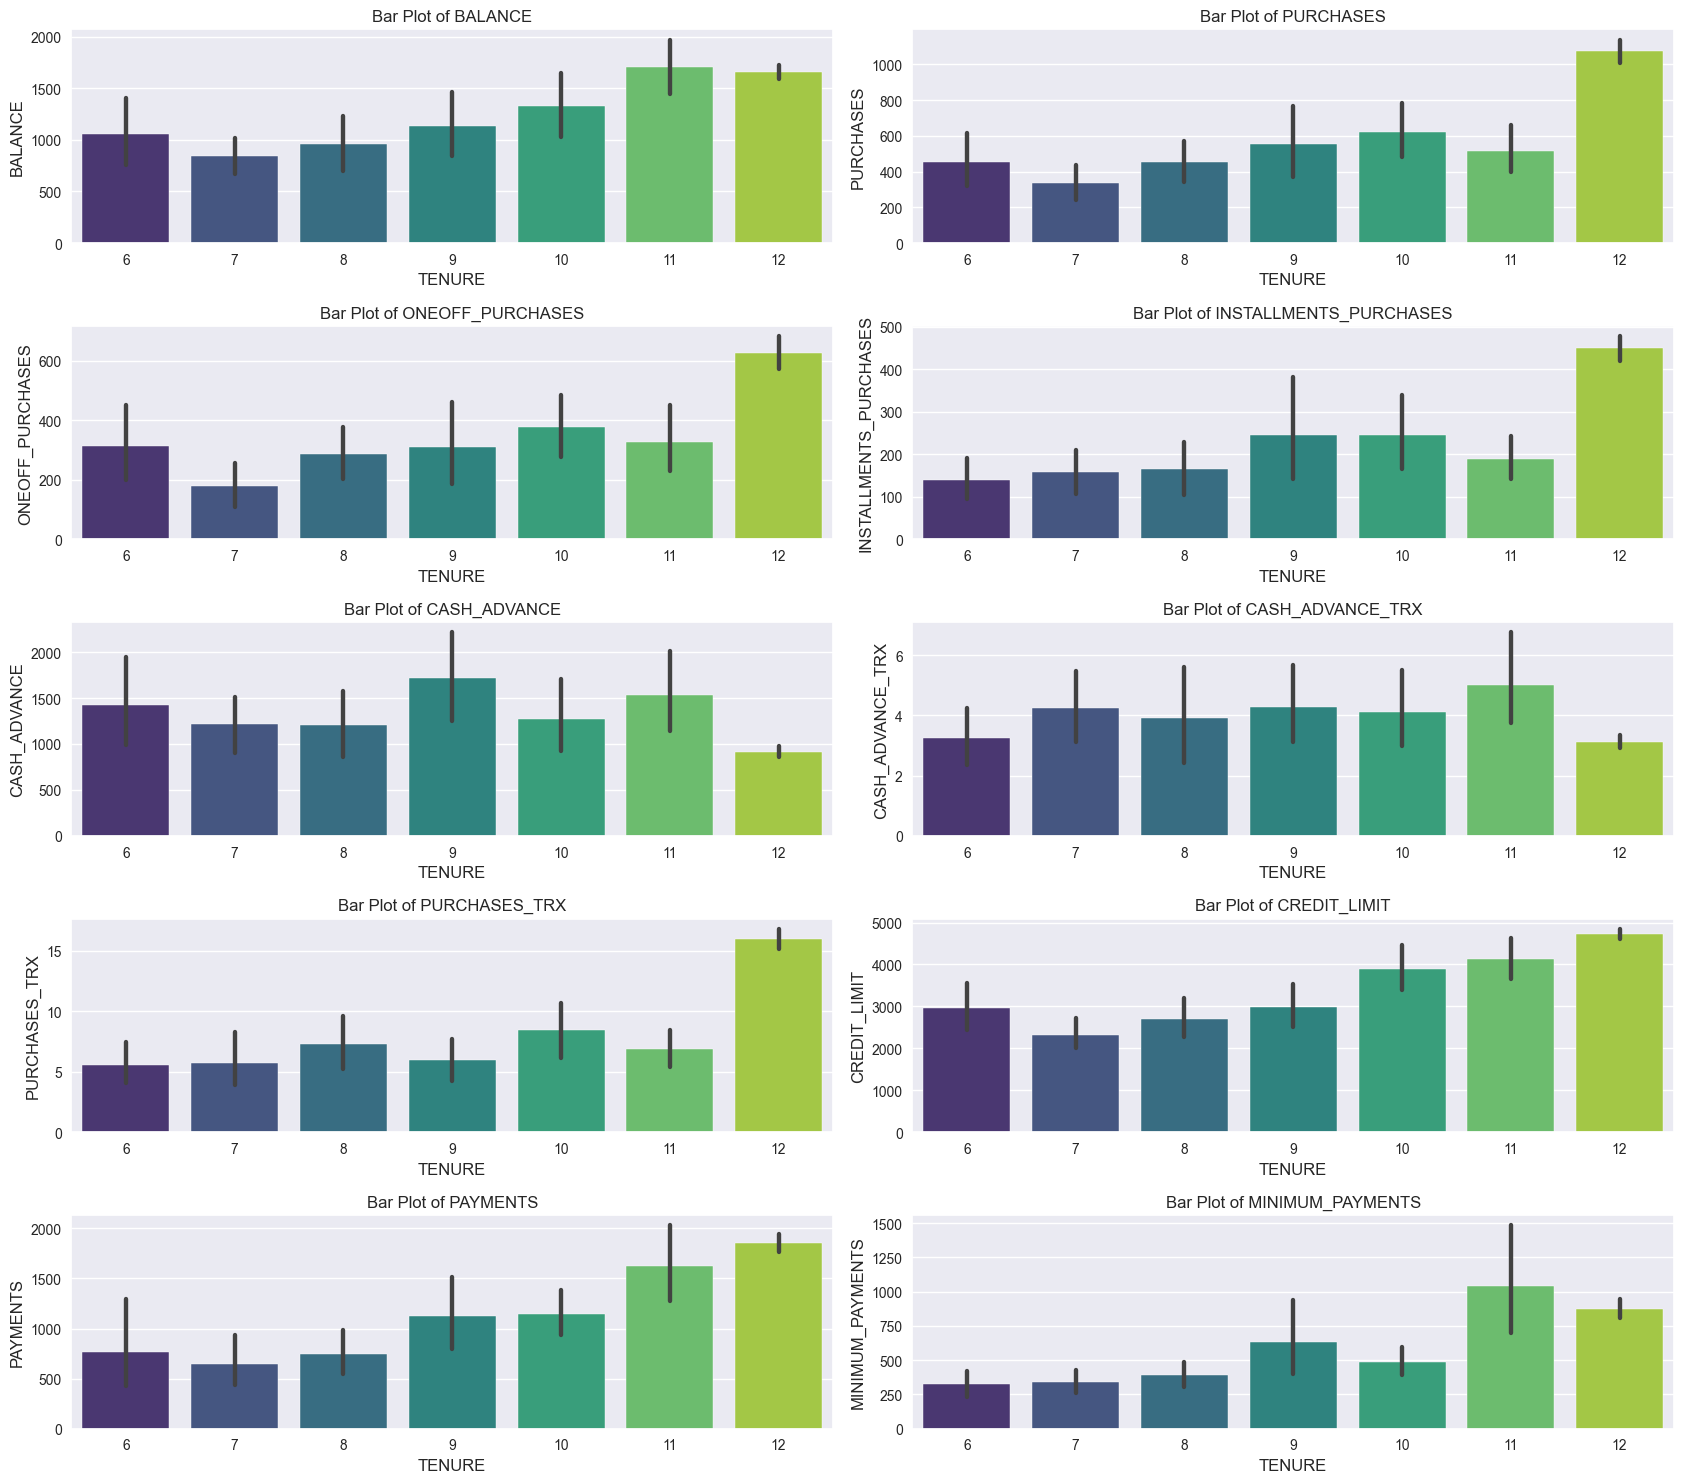

In [442]:
# membuat canvas
fig, axes = plt.subplots(5, 2, figsize=(17, 15))

# membuat bar plot untuk melihat relasi kolom kategorikal 'tenure' dengan kolom numerik
for i, col in enumerate(num_cols):
    ax = axes[i // 2, i % 2]
    sns.barplot(data=df, ax=ax, x='TENURE', y=col, palette='viridis')
    ax.set_title(f'Bar Plot of {col}')
    ax.set_xlabel('TENURE')
    ax.set_ylabel(col)

# show plot
plt.tight_layout()
plt.show()

In [450]:
# melihat rata-rata berdasarkan 'TENURE'
df.groupby(['TENURE'])[['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
       'CASH_ADVANCE', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT',
       'PAYMENTS', 'MINIMUM_PAYMENTS']].mean().sort_values(by = 'BALANCE', ascending = False)

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS
TENURE,,,,,,,,,,
11,1704.704862,518.270056,328.623743,189.646313,1531.775524,5.022346,6.865922,4139.106145,1623.362732,1039.330439
12,1660.461582,1075.429549,627.010003,448.834911,914.887673,3.118635,15.955381,4728.937472,1853.058104,871.367923
10,1325.834031,621.688051,377.349831,244.736525,1270.923537,4.101695,8.406780,3895.762712,1145.289251,488.297071
9,1137.468139,556.418659,312.142317,244.276341,1718.644609,4.280488,5.987805,2997.967480,1124.043487,632.304237
6,1061.718635,453.479062,313.833229,139.645833,1422.466791,3.239583,5.583333,2971.041667,764.997943,324.311799
8,961.827400,452.902258,287.233118,165.669140,1201.995374,3.903226,7.247312,2710.752688,742.789113,390.405967
7,843.720796,336.929375,178.642083,158.287292,1212.335884,4.239583,5.739583,2330.208333,645.275220,337.982118


Dari visualisasi tersebut terlihat bahwa secara umum, peminjam atau pemilik kartu kredit yang sudah menggunakan kartu selama cukup lama akan memiliki sisa 'BALANCE' yang lebih tinggi. Hal ini juga berlaku untuk seluruh kolom lainnya kecuali kolom 'CASH_ADVANCE' dan 'CASH_ADVANCE_TRX'--yang dapat mengasumsikan bahwa semakin lama pemilik kartu memegang kartu, maka dia akan `lebih nyaman` untuk memiliki lebih banyak transaksi. Bisa juga dikarenakan memang data ini memiliki modus 'TENURE' terbanyak pada bulan 12. 

Selain itu, `bertambahnya limit` seiring bertambahnya nilai 'TENURE' dapat menggambarkan meningkatnya skor kredit seseorang sehingga bisa lebih dipercaya oleh kreditur/ *card issuer*. Atau bisa juga karena pemilik kartu sudah lebih nyaman .

Sementara itu, untuk kolom 'CASH_ADVANCE' dan 'CASH_ADVANCE_TRX' memiliki persebaran yang merata terlepas dari bulannya. Hal ini mungkin menunjukkan bahwa peminjaman `uang cash` berlaku untuk seluruh kalangan, baik client baru atau lama (biasanya orang yang membutuhkan urgensi dan membutuhkan pegangan uang secepatnya).

### Conclusion

**Conclusion**

Dari hasil eksplorasi dan visualisasi ada beberapa gambaran serta kesimpulan yang dapat diambil, yakni:

- Kolom kategorikal, frekuensi, dan persentase dihindari untuk memberikan data yang lebih ebrsih (hanya numerikal asli) untuk model Kmeans. 
- Data memiliki outlier pada semua kolom numerikal yang akan ditangani pada bagian pre-processing. 
- Terlihat ada hubungan linear dari kolom kategorikal 'TENURE' serta mayoritas kolom numerikal lainnya. 
- Mayoritas pemilik kartu kredit memiliki limit yang cukup tinggi, namun memiliki minimum payments tiap transaksi yang rendah. Mayoritas lebih sering melakukan *purchase* dibandingkan meminjam uang tunai, serta seringkali menghabiskan saldo kreditnya hingga mencapai limit. Dalam hal frekuensi berbelanja, mayoritas pemilik kartu kredit pada data ini antara sering sekali berbelanja atau tidak pernah berbelanja sama sekali (U-shaped).

# V. Feature Engineering

### Split Inference

In [101]:
# mengambil sample untuk dijadikan inference
data_inf = df_drop.sample(30, random_state=30)
X = df_drop.drop(data_inf.index)

# reset index
data_inf.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)

#memastikan ukuran data latihan dan sample
print(X.shape)
print(data_inf.shape)

(4444, 10)
(30, 10)


### Feature Selection

**Pearson**

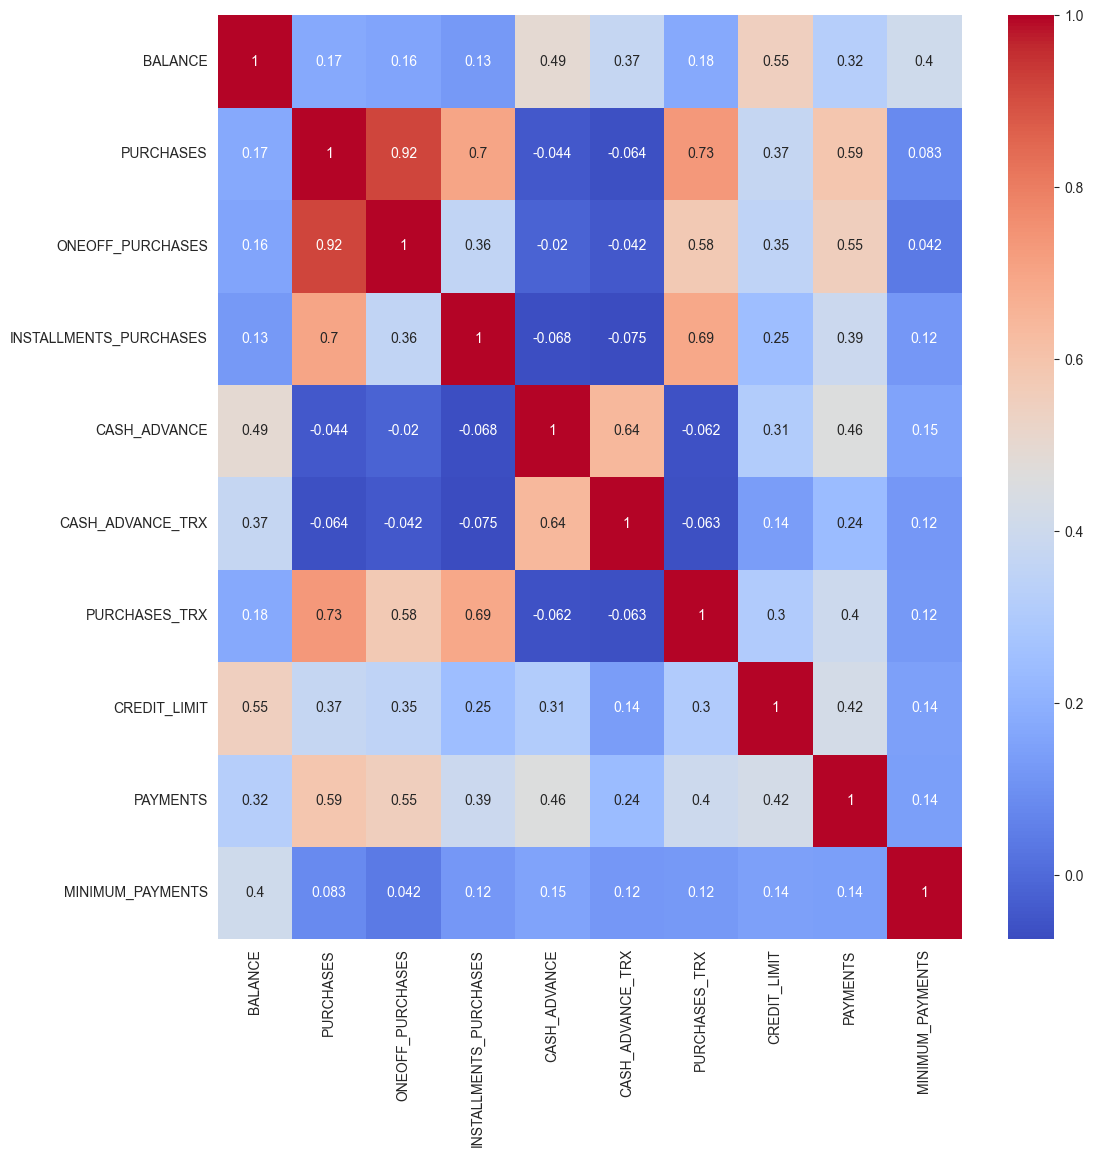

In [102]:
# melihat visualisasi korelasi
plt.figure(figsize=(12,12))
sns.heatmap(df_drop.corr(), annot=True, cmap='coolwarm')
plt.show()

Diketahui bahwa 'CASH_ADVANCE' dan 'CASH_ADVANCE_TRX' memiliki korelasi dengan fitur-fitur lain yang terbilang kecil. 

**VIF**

In [426]:
# membuat fungsi VIF
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.sort_values(by=['VIF'],ascending=False)
    return(vif)
# kalkulasi vif
calc_vif(df_drop)

,variables,VIF
1,PURCHASES,39416.518682
2,ONEOFF_PURCHASES,21286.136450
3,INSTALLMENTS_PURCHASES,7038.913070
8,PAYMENTS,3.369958
6,PURCHASES_TRX,3.335303
4,CASH_ADVANCE,3.309318
0,BALANCE,3.220933
7,CREDIT_LIMIT,2.947655
5,CASH_ADVANCE_TRX,2.065797
9,MINIMUM_PAYMENTS,1.399044


Melihat dari nilai VIF, diketahui bahwa ternyata ada 3 kolom yang memiliki nilai di atas 5. Hal ini kemudian menunjukkan bahwa ada multicollinearity pada kolom-kolom tersebut. Multicollinearity ini dapat direduksi dengan menggunakan PCA--dengan perkiraan dapat direduksi menjadi tiga kolom.

Selanjutnya, telah diketahui bahwa sebelumnya kami telah melakukan filtering kolom kategorikal di bagian eksplorasi. Selain itu, karena pada bagian eksplorasi kami menemukan ada hubungan diantara beberapa kolom tersebut, maka semua fitur yang kini tersisa akan dilanjutkan untuk dilatih dengan model dengan argumen adanya domain knowledge. 

# VI. Feature Engineering: PCA

Pada bagian ini akan digunakan pipeline untuk menggabungkan pre-processing sebelum modelling. Berikut adalah sedikit penjelasan dalam penggunaan tiap transformer:
- Log transform untuk handling outlier: Ditemukan bahwa handling outlier dengan logaritma adalah salah satu metode handling outlier dalam menangani data yang skewed agar menjadi lebih normal. Hal ini diterapkan dengan asumsi bahwa seluruh data memiliki ciri bernilai positif dan skewed. Log transformation bekerja dengan mempertahankan perubahan relatif antar nilai; biasanya ketika perbedaan antar nilai menjadi penting seperti pada `data keuangan` yang sedang kita tangani (sumber: [Feng, Changyoung: Log Transformation for Skewed Data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4120293/#:~:text=The%20log%20transformation%20is%2C%20arguably,normal%20or%20near%20normal%20distribution.)).
- MinMaxScaler untuk scaler: Karena seperti yang sudah dilihat pada EDA sebelumnya, mayoritas dari data berbentuk skewed dan lebih cocok untuk menggunakan MinMaxScaler. 

In [176]:
# handling outlier dengan log transform
log_transform = FunctionTransformer(np.log1p) 
pca = PCA(n_components=0.95)

# Create the pipeline
pipeline = Pipeline([
    ('log_transform', log_transform), # handling outlier
    ('yeo_johnson_transform', YeoJohnsonTransformer()), # agar data lebih normal
    ('scaler', MinMaxScaler()),  # karena data tidak terdistribusi normal
    ('PCA', pca)
])

In [177]:
# perform transformasi dan PCA
df_transformed = pipeline.fit_transform(X)
df_transformed = pd.DataFrame(df_transformed)

In [178]:
# melihat jumlah komponen yang dibutuhkan untuk merepresentasikan 95% dari data
cumsum = np.cumsum(pca.explained_variance_ratio_)
comp = np.argmax(cumsum >= 0.95) + 1
comp

5

Untuk merepresentasikan 95% informasi dari data, dibutuhkan reduksi kolom hingga setidaknya lima kolom 

**EVR**

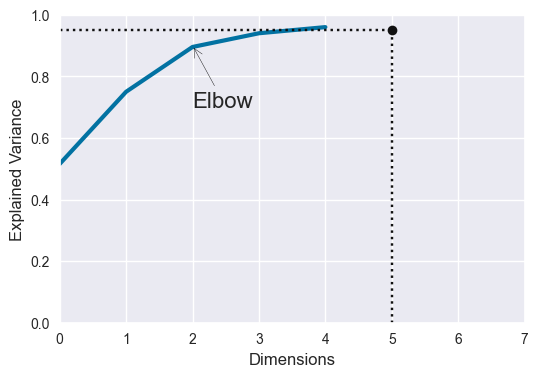

In [179]:
# melihat visualisasi sebagai evaluasi
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 7, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(2, 0.9), xytext=(2, 0.7),
             arrowprops=dict(arrowstyle="->", color = 'black'), fontsize=16)
plt.grid(True)
plt.show()

Karena setelah dilakukan uji Elbow kami mendapatkan nilai 2 dan terlihat bahwa nilai representasi ada di sekitar angka y = 0.9, maka selanjutnya dimensi akan direduksi menjadi 2.

In [263]:
# pendefinisian ulang
pca_2= PCA(n_components=2)# Create the pipeline
pipe_2 = Pipeline([
    ('log_transform', log_transform), # handling outlier
    ('yeo_johnson_transform', YeoJohnsonTransformer()), # agar data lebih normal
    ('scaler', MinMaxScaler()),  # karena data tidak terdistribusi normal
    ('PCA', pca_2)
])


# perform transformasi dan PCA
df_2D = pipe_2.fit_transform(X)
df_transformed = pd.DataFrame(df_2D)

Berikut adalah gambaran persebaran kolom tereduksi secara dua dimensi. Visualisasi yang tergambarkan adalah perbandingan data yang tidak dilakukan *scale* serta data yang telah dilakukan *scale*.

<Axes: >

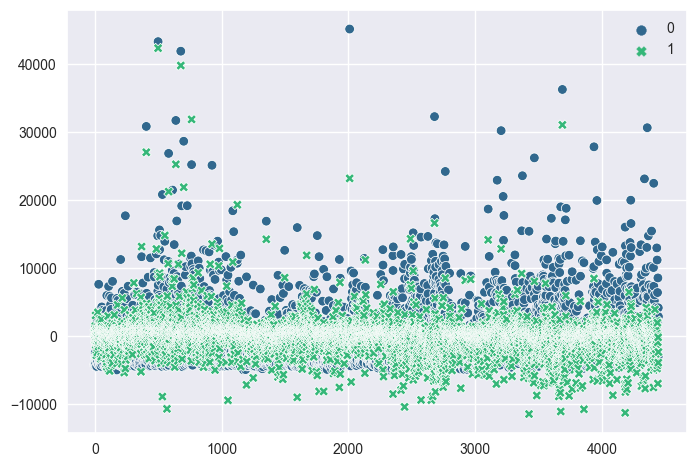

In [288]:
# meilhat visualisai apabila PCA hanya 2D dan data tidak dilakukan scaling serta transformasi lainnya
df_2D_plain_ar = pca_2.fit_transform(X)
df_2D_plain = pd.DataFrame(df_2D_plain_ar)
sns.scatterplot(df_2D_plain, palette = 'viridis')

<Axes: >

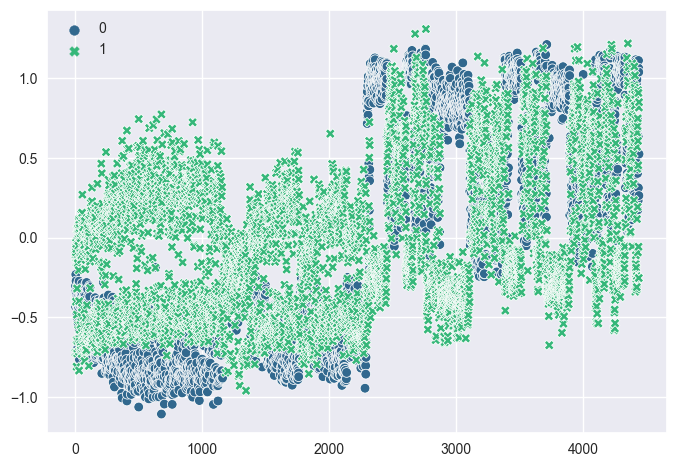

In [287]:
# meilhat visualisai apabila pca menjadi 2 dan data diterapkan scalling, transform, dll
sns.scatterplot(df_2D, palette = 'viridis')

# VI. Modelling

Akan dilakukan pencarian hyperparameter terbaik dengan beberapa metode evaluasi sebelum menentukan jumlah kluster yang tepat.

**Elbow Method**

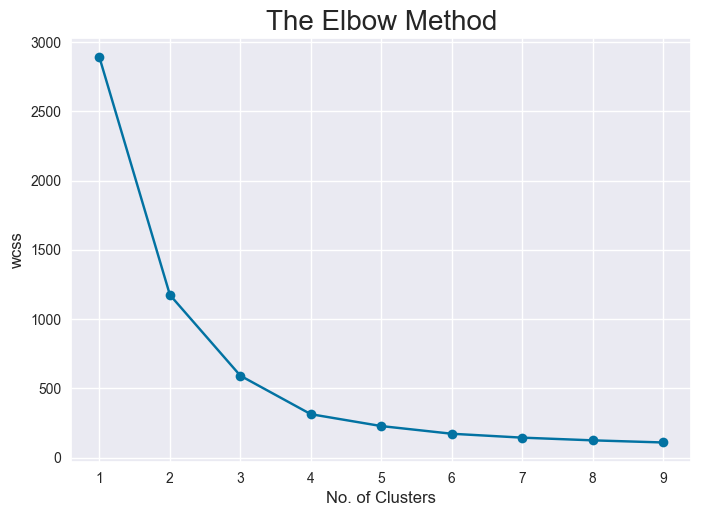

In [205]:
#membuat iterasi dari 1-10 untuk nilai k terbaik
kmeans_models = [KMeans(n_clusters=k, init = 'k-means++', max_iter = 300, n_init = 10, random_state=66).fit(df_transformed) for k in range (1, 10)]
innertia = [model.inertia_ for model in kmeans_models]    
    
plt.plot(range(1, 10), innertia, marker ="o")
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

Diketahui bahwa kluster atau nilai K terbaik adalah sekitar tiga atau empat buah. Selanjutnya akan dicari evaluasi dengan mencari *silhouette score* sebagai perbandingan. 

**Silhouette score**

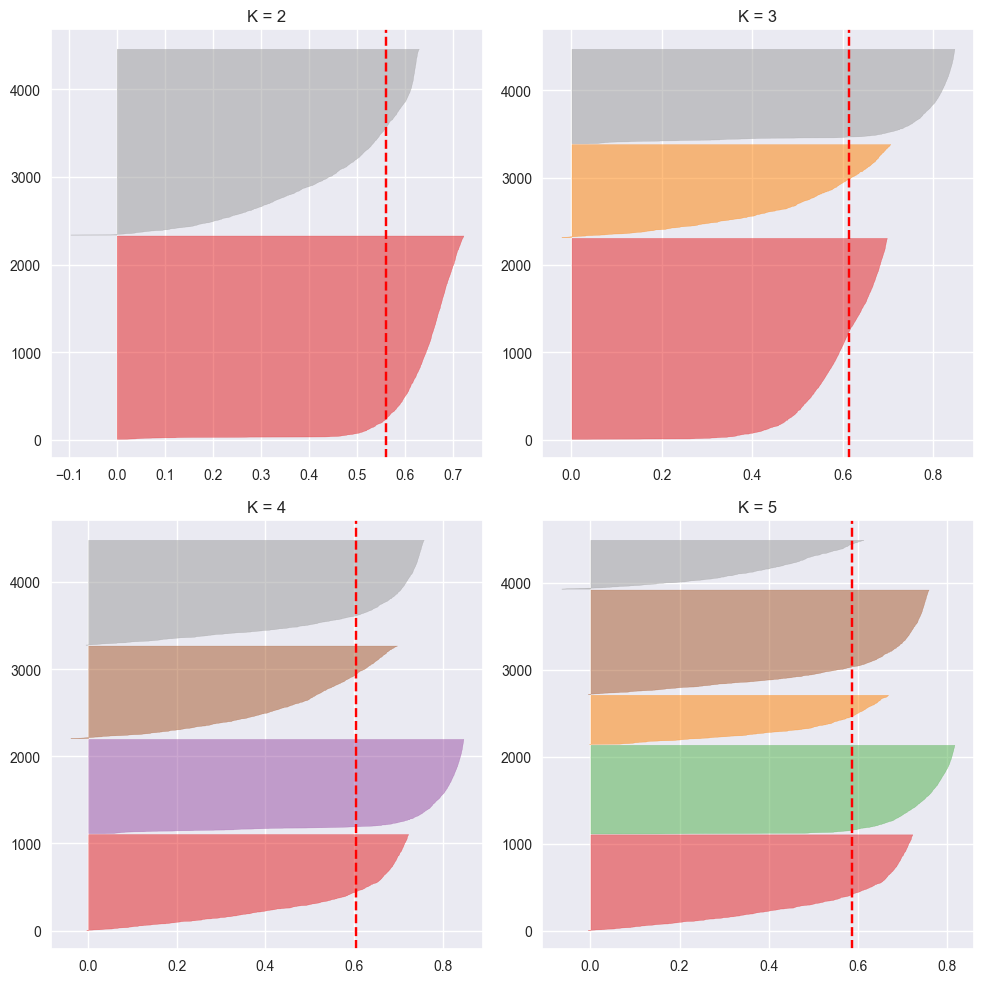

In [291]:
# membuat subplot
fig, axes = plt.subplots(2, 2, figsize=(10,10))


for i, ax in enumerate(axes.flatten()):  
    n_clusters = i + 2 # jumlah cluster
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", n_init = 10, max_iter = 300, random_state = 66)
    visualizer = SilhouetteVisualizer(kmeans, ax=ax)# visualisasi
    visualizer.fit(df_transformed)# fit silhouette viz
    ax.set_title(f'K = {n_clusters}')
    
# show 
plt.tight_layout()
plt.show()


In [275]:
# melihat skor dengan cluster 3
kmeans = KMeans(n_clusters= 3, init="k-means++", n_init = 10, max_iter = 300, random_state = 66)
kmeans.fit(df_transformed)
print('Silhoutte score of 3 Clusters is ' + str(silhouette_score(df_transformed, kmeans.labels_)))

Silhoutte score of 3 Clusters is 0.6138236435382233


In [396]:
# melihat skor dengan cluster 4
kmeans = KMeans(n_clusters= 4, init="k-means++", n_init = 10, max_iter = 300, random_state = 66)
kmeans.fit(df_transformed)
print('Silhoutte score of 4 Clusters is ' + str(silhouette_score(df_transformed, kmeans.labels_)))

Silhoutte score of 4 Clusters is 0.6041198810080625


Diketahui bahwa kluster tiga dan empat mendapatkan niai silhouette yang paling tinggi diantara jumlah kluster lainnya yakni sekitar 0.6. Ternyata kedua evaluasi Elbow maupun Silhouette memberikan jumlah kluster diantara tiga atau empat. Namun berdasarkan pengamatan pribadi, sepertinya kami akan memilik jumlah kluster **empat** karena dianggap memiliki pembagian data yang lebih merata. 

# VII. Model Evaluation

Melihat penyebaran kluster dalam dua dimensi. 

In [250]:
new_transform = pd.DataFrame(df_2D, columns= ['PC1','PC2'])

clusters= kmeans.predict(df_2D)

new_transform['cluster_id']= clusters # kmeans.labels_
new_transform.head()

,PC1,PC2,cluster_id
0,-0.429664,-0.720585,3
1,-0.302205,-0.403119,3
2,-0.337529,-0.107187,3
3,-0.230499,-0.125525,3
4,-0.375819,-0.089551,3


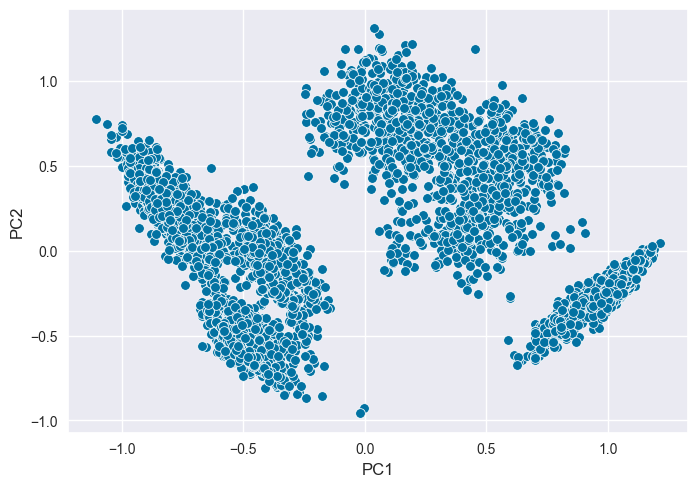

In [279]:
# sebelum dilakukan clustering K means
sns.scatterplot(data=new_transform, x="PC1", y="PC2",palette="viridis");

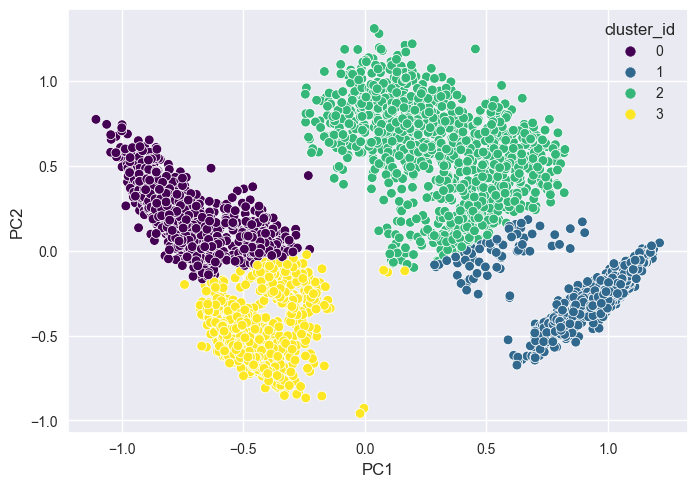

In [251]:
# setelah dilakukan clustering
sns.scatterplot(data=new_transform, x="PC1", y="PC2", hue="cluster_id",palette="viridis");

In [429]:
# melihat nilai inersia
kmeans.inertia_

313.5197476173147

Berikut adalah gambaran pembagian data secara dua dimensi. Jika dilihat secara dua dimensi, sebenarnya terlihat bahwa mungkin ada pola yang lebih baik dibandingkan pola dari model tersebut--terlihat pada beberapa titik data yang terlihat terasingkan dari centroidnya (memiliki jarak). Namun hal tersebut juga mungkin terjadi karena persebaran yang terbentuk dari hasil reduksi memberikan pola yang unik. Sebagai bahan evaluasi nantinya, mungkin algoritma berbasis `density` dapat juga dicoba diterapkan untuk data serta fitur hasil reduksi ini.

Selain itu, nilai inersia memberikan nilai 313.519. Secara prinsip, nilai inersia yang rendah dapat menggambarkan pembagian *clustering* yang lebih baik. Namun karena pada konteks ini kita memiliki sekian banyak data, maka angka tersebut dapat dianggap cukup baik dalam meminimalisir *cluster variance*. 

## VIII. Model EDA 

### Concat

In [ ]:
# Menggabungkan kolom numerikal dengan cluster
df_concat = X.copy()
df_concat['cluster_id'] = kmeans.labels_

In [339]:
# menyiapkan kolom kategorikal yang sebelumnya telah disingkirkan (tenure, dll)
df_cat = df[cat_cols].drop(data_inf.index)

#reset index sebelum concat
df_cat.reset_index(inplace=True)
df_concat.reset_index(inplace=True)

#menggabungkan num, cat, dan cluster
df_concat_cat = pd.concat([df_cat, df_concat], axis=1)
df_concat_cat.drop(['index', 'level_0'], axis=1, inplace=True)
# menghitung jumlah tiap cluster
df_concat_cat.groupby('cluster_id')['cluster_id'].count()

cluster_id
0    1099
1    1081
2    1061
3    1203
Name: cluster_id, dtype: int64

Pembagian data tiap kluster cukup tersebar dengan baik dengan kisaran 1000-1200 data.

### Visualization

**Categorical**

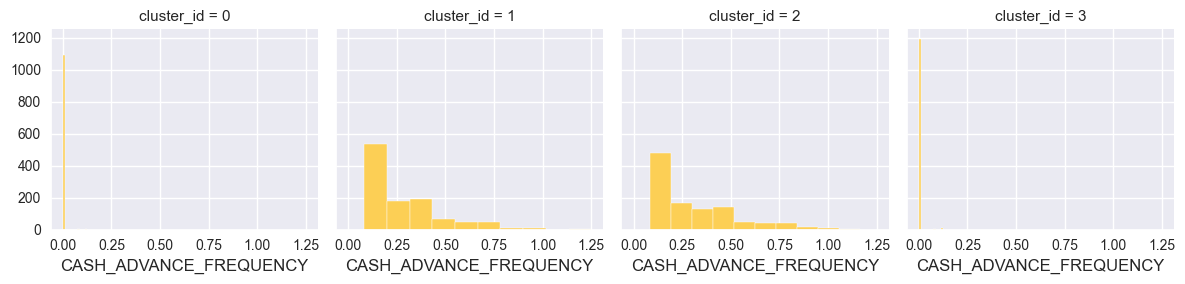

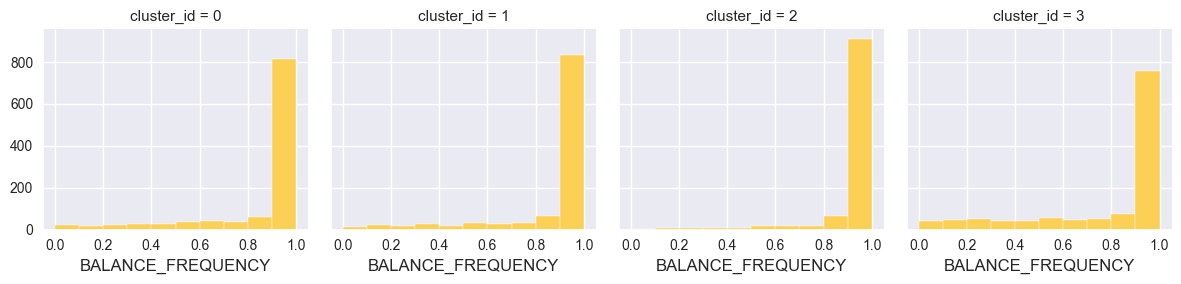

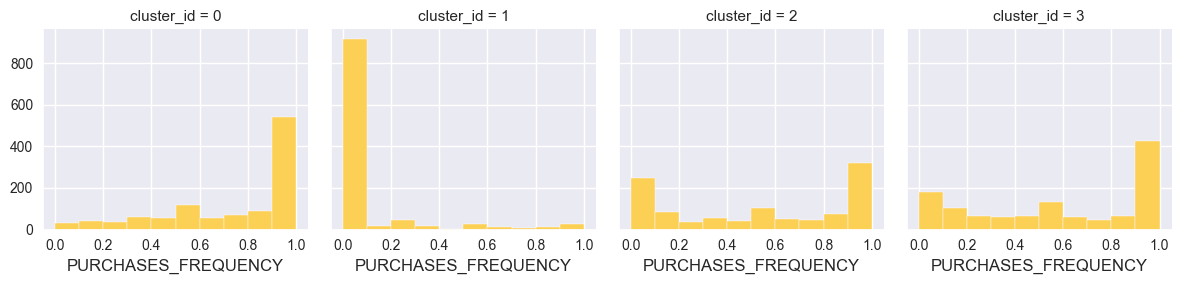

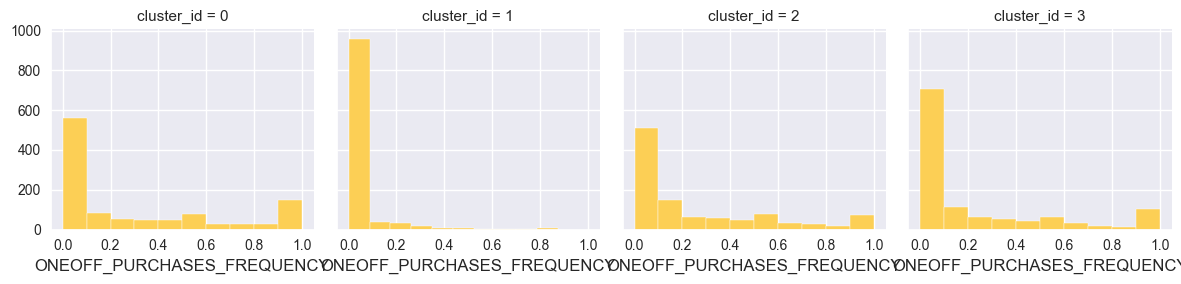

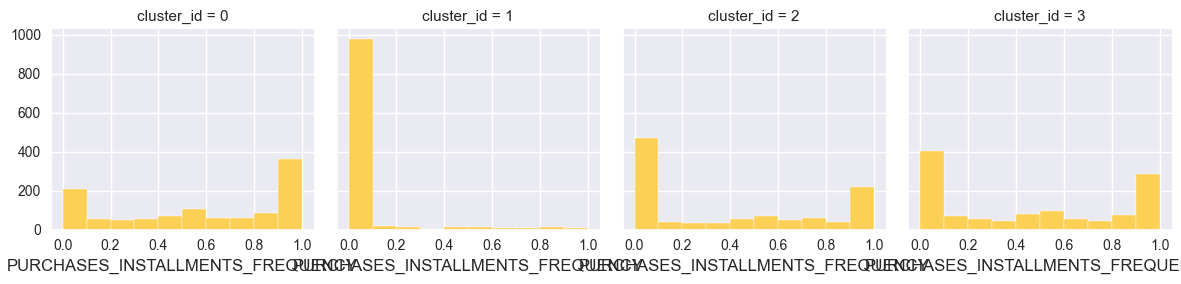

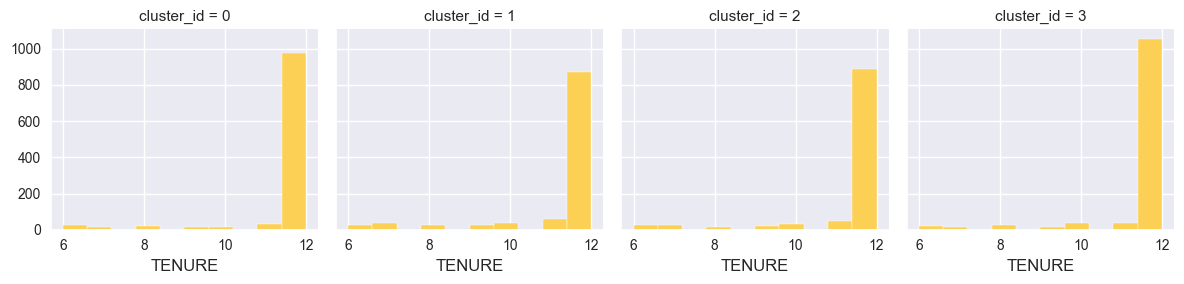

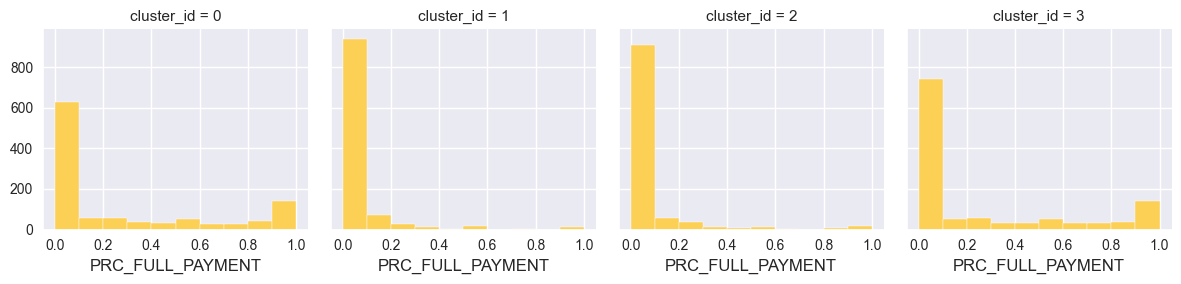

In [425]:
for f in df_concat_cat[cat_cols]:
    grid= sns.FacetGrid(df_concat_cat, col='cluster_id')
    grid.map(plt.hist, f, color = '#fccf55')

**Numerical**

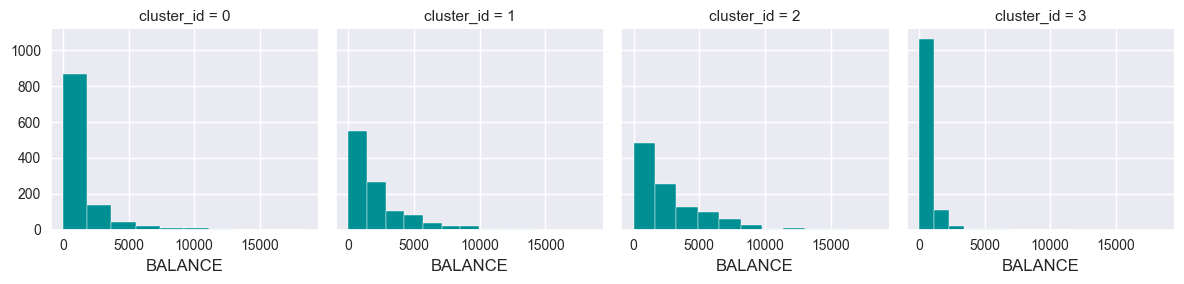

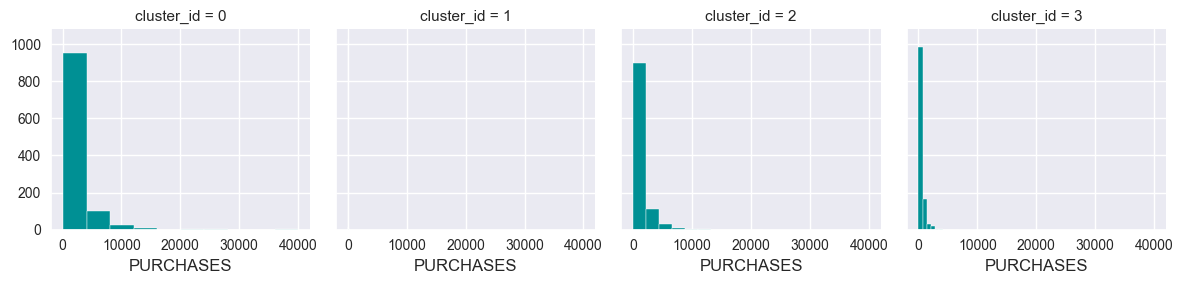

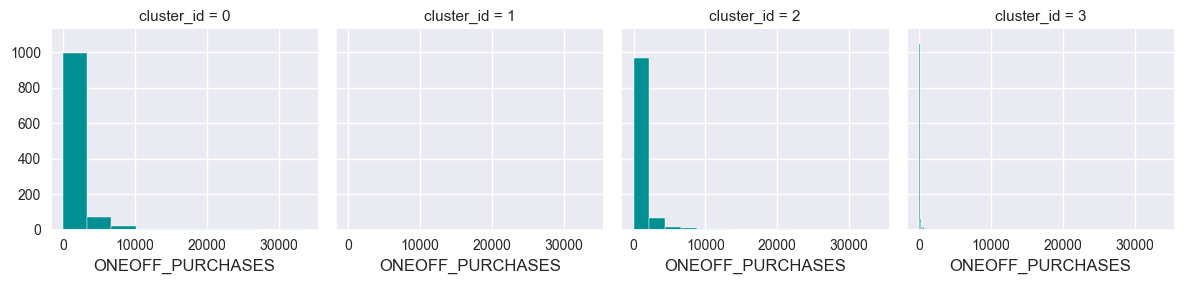

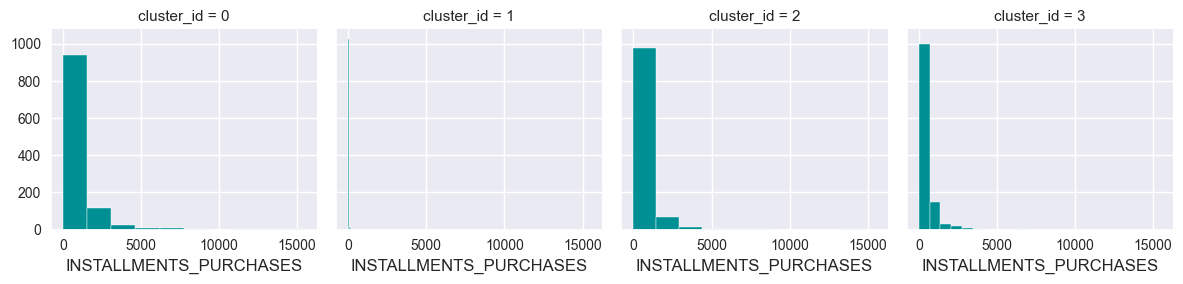

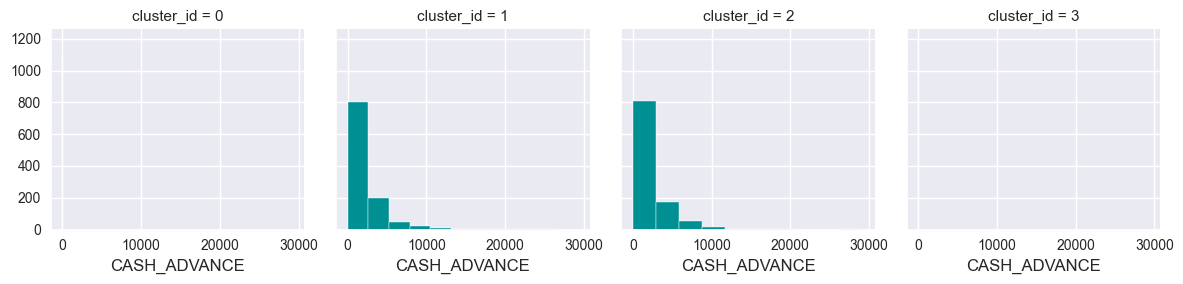

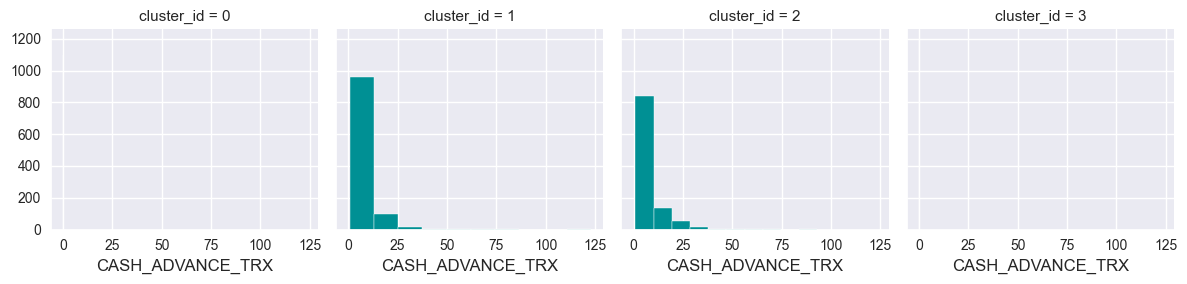

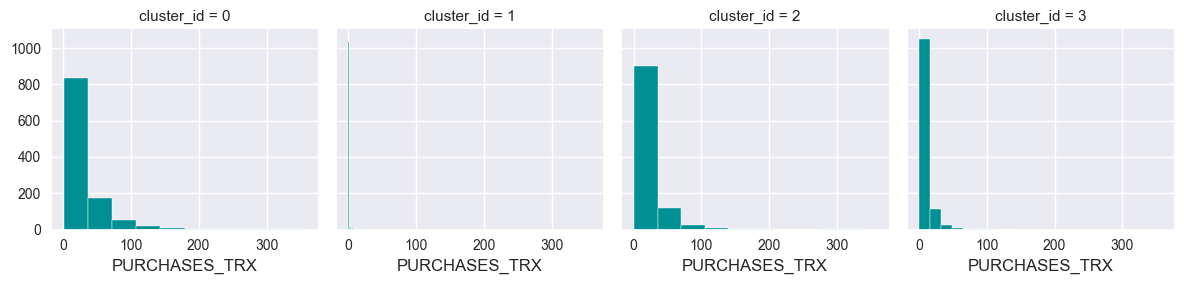

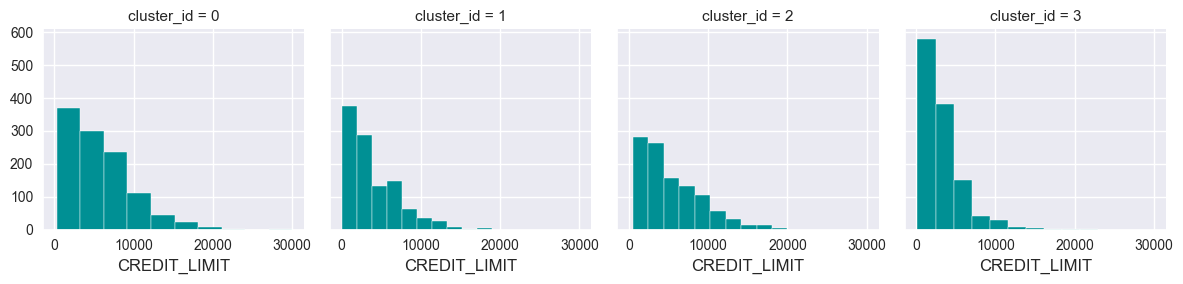

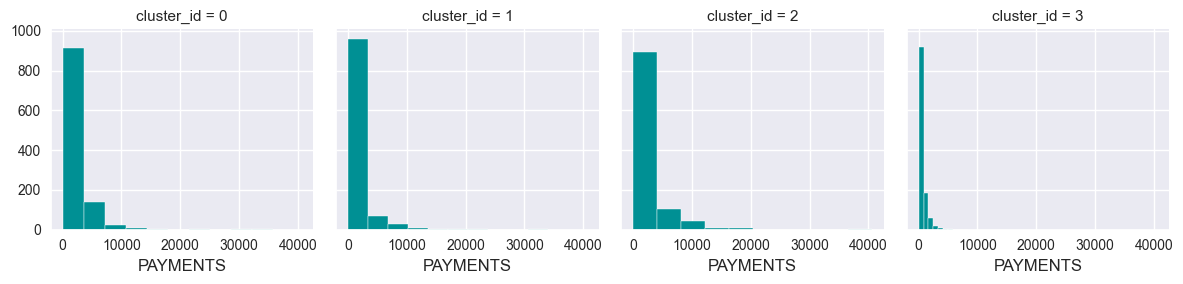

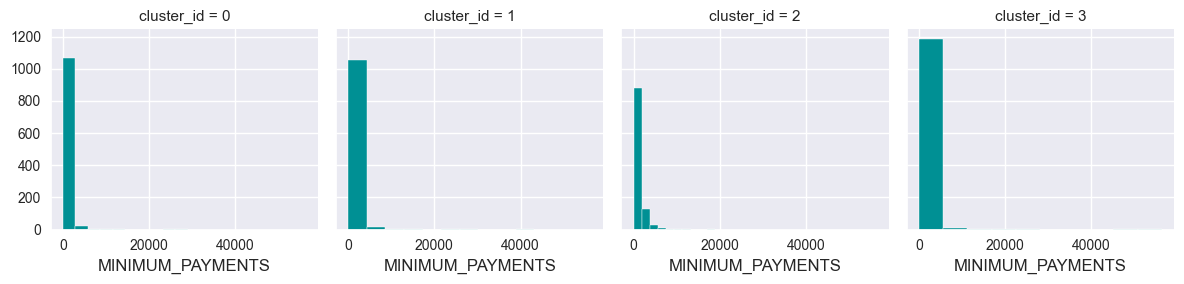

In [420]:
for f in df_concat[num_cols]:
    grid= sns.FacetGrid(df_concat, col='cluster_id')
    grid.map(plt.hist, f, color = '#009094')

In [301]:
# melihat deskripsi data
df_concat.groupby('cluster_id').describe()

BALANCE                                                          \
             count         mean          std  min         25%          50%   
cluster_id                                                                   
0           1099.0  1270.558248  1869.615873  0.0  166.161268   536.425055   
1           1081.0  2134.158615  2155.118532  0.0  689.764098  1400.189725   
2           1061.0  2772.220490  2601.093881  0.0  931.144615  1851.622011   
3           1203.0   394.626335   815.972664  0.0   17.185657    55.707056   

                                     PURCHASES                            \
                    75%          max     count         mean          std   
cluster_id                                                                 
0           1555.219025  18495.55855    1099.0  2296.248408  3262.718509   
1           2785.584338  14224.11541    1081.0     6.216401    30.684980   
2           4006.206157  16304.88925    1061.0  1242.353600  1740.339279   
3            402.799298  11416.64736    1203.0   455.691970   561.106884   

                                                      ONEOFF_PURCHASES  \
              min     25%      50%      75%       max            count   
cluster_id                                                               
0           89.90  721.04  1383.67  2694.05  40040.71           1099.0   
1            0.00    0.00     0.00     0.00    366.68           1081.0   
2           15.92  285.45   662.98  1520.00  22101.78           1061.0   
3            0.01  129.68   284.50   552.80   6897.56           1203.0   

                                                                               \
                   mean          std  min      25%     50%      75%       max   
cluster_id                                                                      
0           1541.008808  2543.587045  0.0  363.855  856.28  1769.35  33803.84   
1              0.096216     1.551615  0.0    0.000    0.00     0.00     32.38   
2            769.027644  1382.708947  0.0   71.900  317.50   920.54  22101.78   
3             53.530274   148.650158  0.0    0.000    0.00     0.00   1200.00   

           INSTALLMENTS_PURCHASES                                        \
                            count        mean          std  min     25%   
cluster_id                                                                
0                          1099.0  755.284186  1291.845946  0.0  60.900   
1                          1081.0    6.182118    30.720140  0.0   0.000   
2                          1061.0  473.897078   867.654568  0.0   0.000   
3                          1203.0  402.916168   584.210700  0.0  37.785   

                                     CASH_ADVANCE                            \
               50%     75%       max        count         mean          std   
cluster_id                                                                    
0           329.15  962.49  15497.19       1099.0     0.018054     0.598511   
1             0.00    0.00    366.68       1081.0  1983.169938  2505.451270   
2           193.50  620.48  14686.10       1061.0  2113.412863  2578.053776   
3           237.66  517.50   6897.56       1203.0     0.236403     5.961021   

                                                                           \
                  min         25%          50%          75%           max   
cluster_id                                                                  
0            0.000000    0.000000     0.000000     0.000000     19.841346   
1           18.149946  368.716548  1148.992175  2698.171001  26194.049540   
2           18.531069  446.945370  1280.423180  2804.350229  29282.109150   
3            0.000000    0.000000     0.000000     0.000000    197.377800   

           CASH_ADVANCE_TRX                                                 \
                      count      mean       std  min  25%  50%  75%    max   
cluster_id                                                          

Dari tabel dan visualisasi tersebut kemudian kita dapat mengambil kesimpulan dari tiap-tiap kluster, yakni:

**Cluster 0**: "The Frequent Shoppers"

Kluster yang memiliki limit `menengah ke atas` dan cukup sering berbelanja.
- Balance tersisa sedikit
- Melakukan baik pembelian tunggal maupun cicilan
- Tidak pernah melakukan `cash` withdrawal
- Sering berbelanja
- Limit menengah ke atas
- Minimum payments kecil

<br><br>
**Cluster 1**: "High Cash-Advance Users"

Memiliki kartu kredit utamanya bukan untuk berbelanja dengan kartu melainkan untuk `meminjam cash`, biasanya orang yang memiliki urgensi tertentu.
- Masih memiliki balance/ saldo belum dipakai
- Belum pernah menggunakan kartu kreditnya (tidak ada total purchase)
- Tidak menggunakan kartu untuk berbelanja langsung, melainkan menggunakan `cash advance`
- Memiliki limit menengah
- Memiliki minimum payments menengah

<br><br>
**Cluster 2**: "The Flexible/ Diverse Users"

Kluster yang memiliki ciri-ciri `melakukan semua jenis metode kredit`. Menggunakan cicilan, tetapi juga meminjam cash, berbelanja one-off juga, dan sebagainya.
- Masih memiliki balance/ saldo belum dipakai
- Menggunakan kartu kredit untuk berbelanja langsung
- Turut meminjam cash
- Memiliki limit menengah ke atas
- Memiliki minimum payments menengah

<br><br>
**Cluster 3**: "The Limited Spenders"

Kluster ini memiliki limit `kecil` namun sering berbelanja. Kluster ini akan berbelanja sampai seluruh balancenya terpakai.
- Balance hampir terpakai semua
- Jummlah purchase sedikit, namun memang memiliki limit kecil
- Tidak pernah melakukan `cash` withdrawal
- Sering berbelanja
- Memiliki limit kecil
- Memiliki minimum payments sedikit besar


**Other Exploration**

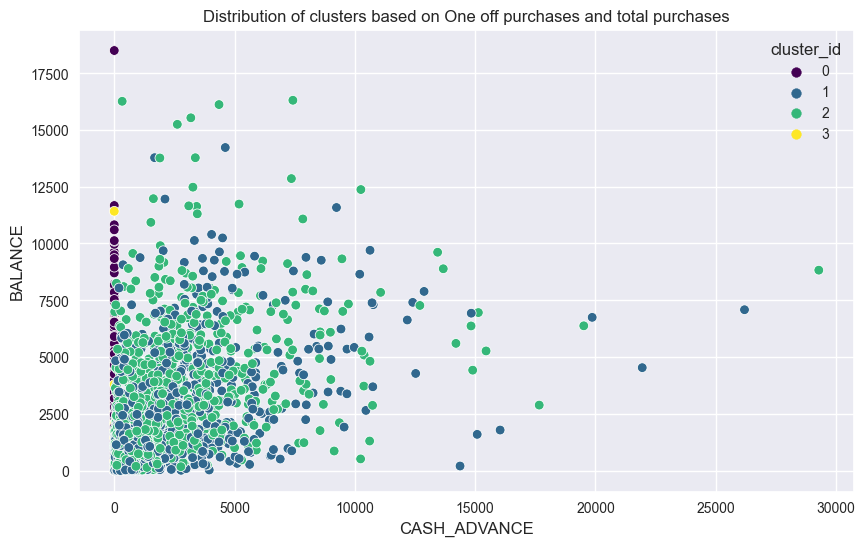

In [466]:
# melihat hubungan kolom dan data yang sudah dicluster
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_concat_cat, x='CASH_ADVANCE', y='BALANCE', hue='cluster_id', palette = 'viridis')
plt.title('Distribution of clusters based on One off purchases and total purchases')
plt.show()

Cluster 1 "High Cash-Advance Users" serta kluster 2 "The Flexible Users" paling banyak melakukan peminjaman uang tunai. Sementara itu, kluster 0 "The Frequent Shoppers" tidak pernah menggunakan peminjaman uang tunai sama sekali. 

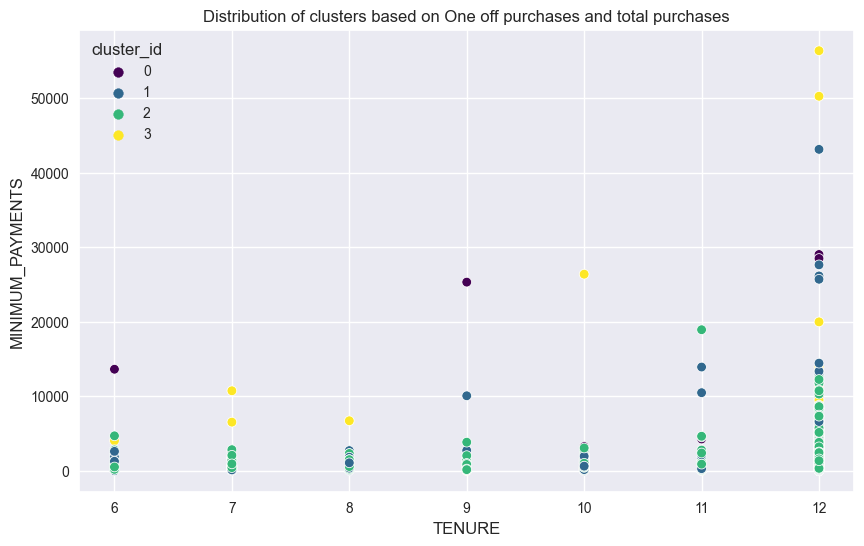

In [464]:
# melihat hubungan kolom dan data yang sudah dicluster
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_concat_cat, x='TENURE', y='MINIMUM_PAYMENTS', hue='cluster_id', palette = 'viridis')
plt.title('Distribution of clusters based on One off purchases and total purchases')
plt.show()

Cluster 3 "The Limited Spenders" memiliki minimum payments yang lebih tinggi. 

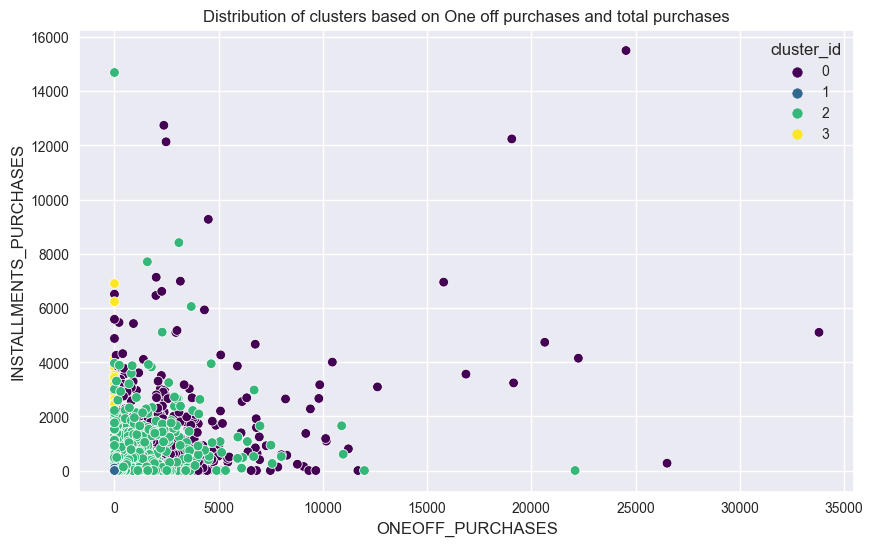

In [465]:
# melihat hubungan kolom dan data yang sudah dicluster
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_concat_cat, x='ONEOFF_PURCHASES', y='INSTALLMENTS_PURCHASES', hue='cluster_id', palette = 'viridis')
plt.title('Distribution of clusters based on One off purchases and total purchases')
plt.show()

Cluster 2 "The Flexible Users" paling banyak melakukan berbagai macam purchase. Cluster 1, "High Cash-Advance Users" hampir tidak terlihat karena mereka jarang/ tidak pernah melakukan purchase; melainkan lebih sering meminjam uang tunai. 

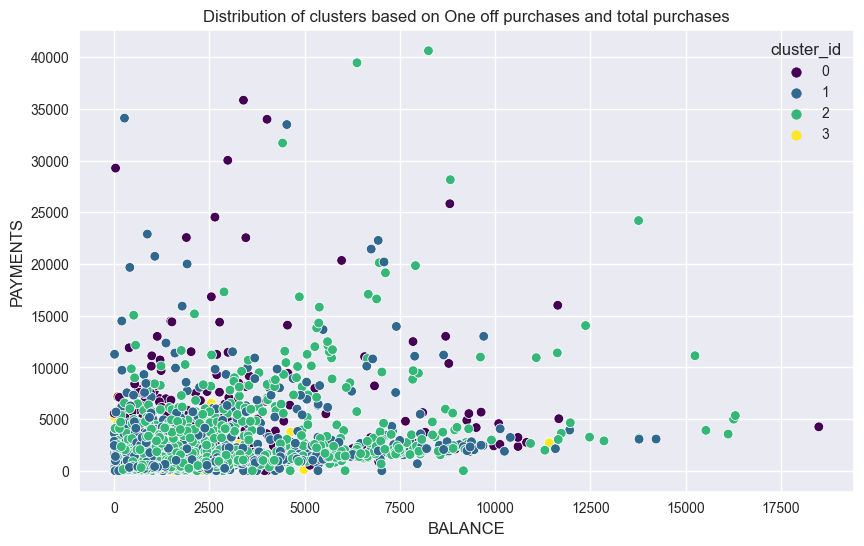

In [469]:
# melihat hubungan kolom payments dan data yang sudah dicluster
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_concat_cat, x='BALANCE', y='PAYMENTS', hue='cluster_id', palette = 'viridis')
plt.title('Distribution of clusters based on One off purchases and total purchases')
plt.show()

Cluster 3 "The Limited Spenders" adalah kluster yang paling jarang melakukan pembayaran/ pelunasan kartu kredit. 

Hasil eksplorasi memberikan argumen yang sejalan dengan pemetaan kluster dan kesimpulan pada bagian visualisasi sebelumnya.

### Remarks

Perlu diketahui bahwa masih perlu dilakukan eksplorasi yang lebih dalam terhadap data dan model, terutama karena model hanya memiliki silhouette score sekitar 60% yang menandakan data belum terbagi secara sempurna. Bisa jadi, ada suatu informasi yang memberatkan fitur sehingga menimbulkan bias (misalnya, ada klien yang jarang berbelanja namun dikelompokkan kedalam Cluster 0 "The Frequent Shoppers" hanya karena klien memiliki limit yang sangat tinggi). Namun secara garis besar, model ini sudah cukup untuk mengetahui tiap-tiap tipe klien yang kita miliki. 

# VIII. Model Inference

### Model Save and Load

Dilakukan simulasi save & load model untuk memastikan bahwa file model juga dapat digunakan pada file notebook lain.

In [403]:
# menyimpan model
with open('pipe_2.pkl', 'wb') as file_1:
  pickle.dump(pipe_2, file_1)

with open('kmeans.pkl', 'wb') as file_2:
  pickle.dump(kmeans, file_2)

In [405]:
# membuka model
with open('pipe_2.pkl', 'rb') as file_1:
  pipe_2_inf= pickle.load(file_1)

with open('kmeans.pkl', 'rb') as file_2:
  kmeans_inf= pickle.load(file_2)

### Inferencing

In [304]:
# menampilkan data inference yang sebelumnya telah dibuat
data_inf.head()

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS
0,607.880635,0.00,0.0,0.00,2266.490818,3,0,1200.0,2379.418142,299.913534
1,2080.122570,0.00,0.0,0.00,3014.915206,7,0,3000.0,652.357962,506.798212
2,1502.292117,0.00,0.0,0.00,188.762242,1,0,4600.0,544.978537,368.962968
3,54.327257,346.02,0.0,346.02,0.000000,0,11,4500.0,237.839366,136.712954
4,307.127754,909.30,409.3,500.00,237.378894,4,12,1000.0,943.278170,179.258575


In [406]:
# perform transformasi dan PCA
df_inf_result = pipe_2_inf.fit_transform(data_inf)
df_inf_result = pd.DataFrame(df_inf_result)

In [471]:
# predict model
cluster_inf = kmeans.predict(df_inf_result)

# menambahkan kolom segmentasi berdasarkan kmeans
inf_result= data_inf.copy()
inf_result['cluster_id'] = cluster_inf

inf_result.head(6)

,BALANCE,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,cluster_id
0,607.880635,0.00,0.00,0.00,2266.490818,3,0,1200.0,2379.418142,299.913534,1
1,2080.122570,0.00,0.00,0.00,3014.915206,7,0,3000.0,652.357962,506.798212,1
2,1502.292117,0.00,0.00,0.00,188.762242,1,0,4600.0,544.978537,368.962968,1
3,54.327257,346.02,0.00,346.02,0.000000,0,11,4500.0,237.839366,136.712954,3
4,307.127754,909.30,409.30,500.00,237.378894,4,12,1000.0,943.278170,179.258575,2
5,831.835714,750.02,588.02,162.00,477.128277,7,13,1200.0,215.867749,171.272347,2


In [414]:
# menghitung jumlah tiap cluster terbentuk
inf_result.groupby('cluster_id')['cluster_id'].count()

cluster_id
0    8
1    9
2    5
3    8
Name: cluster_id, dtype: int64

Bila diteliti pada data dibarisan pertama, diketahui bahwa pemilik kartu kredit tersebut termasuk ke dalam Cluster 1 "High Cash-Advance Users" karena meminjam uang tunai serta tidak melakukan purchase sama sekali. Data pada baris ke-4 (index ke-3) termasuk ke dalam Cluster 3 "The Limited Spenders" karena memiliki balnace yang cukup rendah namun memiliki purchase serta payments yang cukup tinggi.

Eksplorasi secara manual tersebut menandakan bahwa model sudah dapat bekerja dan siap diuji dengan data baru.



# IX. Concept & Conclusion

## Concept

**1. Inertia pada algoritma K-Means:**

Inertia pada algoritma K-Means adalah suatu metrik yang digunakan untuk mengukur sejauh mana titik-titik data dalam sebuah kluster cenderung berada dekat dengan pusat kluster (centroid) mereka sendiri. Inertia dihitung dengan menjumlahkan jarak kuadrat antara setiap titik data dalam kluster dengan pusat kluster yang sesuai. Tujuan dari K-Means adalah untuk `mengoptimalkan inertia`, yaitu mengurangi jarak antara titik-titik data dalam kluster yang sama. (sumber: [jcchouinard](https://www.jcchouinard.com/kmeans/#:~:text=KMeans%20inertia%2C%20also%20known%20as,values%20minus%20the%20means%2C%20squared.))

**2. Elbow Method:**

Elbow Method adalah sebuah metode yang digunakan untuk membantu menentukan jumlah optimal dari kluster (k) dalam algoritma K-Means. Metode ini disebut "Elbow" karena jika kita memplot jumlah kluster (k) terhadap inertia, grafik akan membentuk lengkungan yang menyerupai siku (elbow).

Penggunaan:
- Elbow Method digunakan untuk memilih jumlah kluster yang optimal dalam K-Means. Hal ini penting karena menentukan jumlah kluster yang tepat dapat mempengaruhi hasil analisis dan interpretasi data.
- Dengan menggunakan Elbow Method, kita dapat mencari titik di mana penurunan inertia yang dihasilkan oleh penambahan kluster berikutnya menjadi lebih lambat secara signifikan. Titik tersebut kemudian dianggap sebagai jumlah kluster yang optimal.

Cara penggunaan:
- Pertama, jalankan algoritma K-Means dengan berbagai jumlah kluster (misalnya, k=1 hingga k=n, di mana n adalah jumlah maksimal kluster yang diizinkan).
- Hitung nilai inertia untuk setiap k.
- Plot grafik jumlah kluster (k) terhadap inertia.
- Perhatikan grafik dan cari `titik di mana penurunan inertia` tidak lagi signifikan.
- Jumlah kluster di titik tersebut dianggap sebagai jumlah kluster yang optimal.

Kelebihan dan kelemahan:
- Kelebihan Elbow Method adalah metode yang sederhana dan intuitif untuk menentukan jumlah kluster yang optimal. Ini dapat memberikan panduan awal yang baik dalam eksplorasi data.
- Namun, Elbow Method tidak selalu memberikan hasil yang jelas. Terkadang grafik `tidak membentuk lengkungan yang jelas` seperti siku, sehingga sulit untuk memilih jumlah kluster yang optimal.
- Elbow Method hanya memberikan indikasi awal dan bergantung pada interpretasi visual, sehingga keputusan akhir tetap bergantung pada penilaian manusia.

Oleh karena itu kita perlu melakukan evaluasi lebih lanjut terhadap pemilihan jumlah kluster menggunakan metode lain (seperti *silhouette score*, dll) atau dengan domain pengetahuan yang lebih dalam. (sumber: [Towards Data Science](https://towardsdatascience.com/elbow-method-is-not-sufficient-to-find-best-k-in-k-means-clustering-fc820da0631d#:~:text=The%20elbow%20method%20is%20a,cluster%20and%20the%20cluster%20centroid.))

## Recommendation

Bagian ini akan membahas rekomendasi serta strategi untuk tiap kluster sesuai dengan domain kredit dan keuangan.

**Cluster 0** "The Frequent Shoppers":
- Dapat diberikan insentif atau reward khusus untuk setiap transaksi yang dilakukan. Misalnya program cashback, diskon khusus, atau poin reward.
- Serupa dengan poin pertama, memberi hadiah/ limited item yang hanya akan didapatkan oleh klien dengan limit tinggi dan sering berbelanja. Hal ini akan memotivasi klien untuk terus menggunakan jasa kredit.
- Tawarkan opsi pembayaran cicilan yang fleksibel agar mereka tetap dapat berbelanja tanpa terbebani oleh pembayaran yang besar.
- Berikan rekomendasi produk atau penawaran spesial berdasarkan preferensi pembelanjaan sebelumnya.
- Menyediakan pilihan pembayaran yang fleksibel dan mudah seperti pembayaran melalui aplikasi atau sistem pembayaran online. Hal ini akan memudahkan mereka untuk belanja dimana saja karena kluster ini memang merupakan kluster yang suka belanja. 

**Cluster 1** "High Cash Advance Users":
- Berikan informasi mengenai alternatif lain yang dapat membantu klien dalam situasi keuangan darurat, seperti pinjaman pribadi atau program keuangan yang lebih sesuai dengan kebutuhan mereka.
- Tawarkan program managemen keuangan yang dapat membantu mereka dalam mengelola keuangan mereka dengan lebih baik, sehingga mereka tidak selalu bergantung pada *cash advance*.
- Ajak mereka untuk turut menggunakan kartu kredit untuk berbelanja secara langsung (*purchase*) juga dengan memberikan insentif atau promo menarik.

**Cluster 2**: "The Flexible/ Diverse Users"
- Tingkatkan komunikasi dan interaksi secara personal. Pahami preferensi dan kebutuhan mereka dengan lebih baik, dan berikan penawaran yang sesuai.
- Berikan pilihan pembayaran yang beragam, seperti pembayaran cicilan atau *cash advance*, agar mereka dapat memilih sesuai dengan kebutuhan dan preferensi mereka.
- Monitor transaksi mereka secara cermat untuk mengidentifikasi pola pembelanjaan dan memberikan rekomendasi produk atau layanan yang relevan.
- Klien pada kluster ini akan mencoba berbagai jenis metode pembayaran. Klien ini adalah klien yang peling cocok untuk dikenalkan pada program-program baru karena fleksibilitasnya. 

**Cluster 3** "The Limited Spenders":
- Menawarkan program cicilan dengan bunga rendah atau tanpa bunga. Hal ini akan membantu mereka dalam melunasi pembelian mereka dengan lebih mudah.
- Memberikan saran dan rekomendasi produk atau layanan yang relevan dengan kebiasaan belanja--seperti membuat bundle, dan sebagainya.
- Tawarkan program penghematan atau diskon khusus.
- Berikan informasi mengenai cara mengelola keuangan dengan bijak, termasuk cara mengatur pembayaran dan strategi penghematan.

Selain strategi di atas, penting juga untuk terus memantau dan menganalisis perilaku dan kebutuhan klien di setiap kluster. Dengan pemahaman yang mendalam tentang preferensi dan kebiasaan mereka, kita dapat terus mengembangkan strategi yang lebih efektif untuk mempertahankan klien sebagai pengguna jasa kredit.

## Conclusion

**1. Data Exploration**

Dari hasil eksplorasi dan visualisasi ada beberapa gambaran serta kesimpulan yang dapat diambil, yakni:

- Kolom kategorikal, frekuensi, dan persentase dihindari untuk memberikan data yang lebih ebrsih (hanya numerikal asli) untuk model K-means. 
- Data memiliki outlier pada semua kolom numerikal yang akan ditangani pada bagian pre-processing. 
- Terlihat ada hubungan linear dari kolom kategorikal 'TENURE' serta mayoritas kolom numerikal lainnya. 
- Mayoritas pemilik kartu kredit memiliki limit yang cukup tinggi, namun memiliki minimum payments tiap transaksi yang rendah. Mayoritas lebih sering melakukan *purchase* dibandingkan meminjam uang tunai, serta seringkali menghabiskan saldo kreditnya hingga mencapai limit. Dalam hal frekuensi berbelanja, mayoritas pemilik kartu kredit pada data ini antara sering sekali berbelanja atau tidak pernah berbelanja sama sekali (U-shaped).

**2. Modelling**

- Mendapatkan nilai tiga sebagai jumlah kluster terbaik menurut evaluasi elbow dan silhouette.
- Namun kami mengambil empat kluster karena merasa pembagian tiap kluster lebih merata dan seimbang. 
- Masih dapat dilakukan percobaan lainnya untuk menyesuaikan pembagian yang diinginkan.


**3. Clusters**
- Model membagi data menjadi empat kluster, yakni "The Frequent Shoppers", "High Cash Advance Users", "The Flexible/ Diverse Users", serta "The Limited Spenders". Ciri-ciri dari tiap kluster telah disebutkan pada bagian EDA model. Tiap-tiap kluster memiliki strategi yang berbeda-beda, sehingga menjadi keputusan perusahaan untuk memfokuskan pada satu target (misalnya Cluster 0 yang terkesan loyal), atau jika ingin memaksimalkan tiap-tiap kluster sesuai dengan kemampuan dan budget perusahaan. 



**4. Model Evaluation**

- Masih perlu dilakukan eksplorasi yang lebih dalam terhadap data dan model, terutama karena model hanya memiliki silhouette score sekitar 60% yang menandakan data belum terbagi secara sempurna.
- Masih ada kemungkinan model melakukan salah prediksi/ bias jika melakukan prediksi pada tiap-tiap `individu` karena ada bobot fitur yang tercampur saat proses reduksi. 
- Namun secara garis besar, model ini sudah baik untuk mengetahui tiap-tiap tipe klien yang kita miliki jika clustering merupakan tujuan utama (lebih untuk mengetahui tipe dan mencari strategi, bukan untuk memprediksi tiap-tiap individu secara mendetail dan pasti).



**5. Further Improvement**

- Dapat dilakukan feature selection yang berbeda berdasarkan uji lainnya
- Dapat dilakukan transformasi lain (seperti metode scalling yang lebih tepat, metode outleir handling yang lebih targeted, dll) saat preprocessing untuk meningkatkan metrik-metrik evaluasi seperti meningkatkan silhouette score, dll
- Dapat mencoba jumlah kluster lain yang memiliki *score silhouette* dan metrik lain lebih tinggi. Percobaan penggantian jumlah kluster juga dapat dilakukan pada model yang sudah dilakukan preprocessing yang lebih sesuai. 
- Dapat dilakukan modelling lainnya yang mungkin lebih sesuai dengan persebaran data yang telah tereduksi, seperti misalnya *density-based* model dan lainnya.